# Machine Learning Portfolio 2

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modeling](#modeling)

- [Results](#results)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [101]:
# Libraries

import os
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

## Data Overview

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [102]:
train = pd.read_csv('train.csv', parse_dates=['date_hour'], index_col='date_hour')
test = pd.read_csv('test.csv', parse_dates=['date_hour'], index_col='date_hour')
sample_submission = pd.read_csv('sample_submission.csv')

In [103]:
# Train and Test data
display(train.head(10), test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,1
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,3
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,8


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343


In [104]:
# Sample submission for kaggle
display(sample_submission.head(10))

,date_hour,cnt
0,2012-12-01 00:00:00,784
1,2012-12-01 01:00:00,80
2,2012-12-01 02:00:00,605
3,2012-12-01 03:00:00,604
4,2012-12-01 04:00:00,544
5,2012-12-01 05:00:00,100
6,2012-12-01 06:00:00,344
7,2012-12-01 07:00:00,18
8,2012-12-01 08:00:00,57
9,2012-12-01 09:00:00,603


## Exploratory Data Analysis

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.0 MB


#### Data Types:  

Er zijn verschillende data types aanwezig:
- **datetime**: date_hour
- **Integer**: holiday, weathersit en cnt
- **Float**: temp, atemp, hum en windspeed

In [106]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


#### Controle op Ontbrekende Waarden

In [107]:
print(train.isnull().sum())

holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

#### Vorm van de gegevens

In [108]:
print(train.shape)

(16637, 7)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

#### Kolommen beschrijven:  
- **date_hour**: Datum en tijdstip.
- **holiday**: Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit**: De beschrijving van de weersomstandigheden op een schaal van 1 tot 4, waarbij 1 goed weer is en 4 heel slecht weer.
- **temp**: Genormaliseerd temperatuur
- **atemp**: Genormaliseerd gevoelstemperatuur
- **hum**: Genormaliseerd luchtvochtigheid
- **windspeed**: Genormaliseerd windsnelheid
- **cnt**: Aantal verhuurd

#### Het meetniveau voor elke kolom:  
- **date_hour**: Interval
- **holiday**: Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit**: Ordinaal (categorieën hebben een volgorde).
- **temp**: Interval (continue variabele).
- **atemp**: Interval (continue variabele).
- **hum**: Interval (continue variabele).
- **windspeed**: Interval (continue variabele).
- **cnt**: Ratio

In [109]:
def resample_datetime(df):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['week_of_year'] = data.index.isocalendar().week
    data['day_of_year'] = data.index.day_of_year
    data['day_of_month'] = data.index.day
    data['day_of_week'] = data.index.weekday
    data['hour'] = data.index.hour
    return data

In [110]:
data = resample_datetime(train)
display(data)

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,52,1,1,5,0
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,52,1,1,5,1
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,52,1,1,5,2
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,52,1,1,5,3
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,52,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,48,335,30,4,19
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,48,335,30,4,20
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,48,335,30,4,21


### Visualiseren

In [169]:
class DataVisualizer:
    def __init__(self, dataframe):
        # Ensure the dataframe has a datetime index
        if not isinstance(dataframe.index, pd.DatetimeIndex):
            raise ValueError("The dataframe index must be a DatetimeIndex.")
        self.df = dataframe.copy()
        sns.set_style('darkgrid')

    def plot_time_series(self, value_col, year=None, title="Time Series Analysis", xlabel="Time", ylabel="Value"):
        """
        Plots a time series for a specific column, optionally filtered by year.
        
        Parameters:
            value_col (str): The column to plot.
            year (int, optional): The year to filter the data. If None, plots all years.
            title (str): The title of the plot.
            xlabel (str): The label for the x-axis.
            ylabel (str): The label for the y-axis.
        """
        data_to_plot = self.df
        if year is not None:
            data_to_plot = data_to_plot[data_to_plot.index.year == year]
            title += f" ({year})"
        
        plt.figure(figsize=(14, 6))
        plt.plot(data_to_plot.index, data_to_plot[value_col])
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_distributions(self, continuous_cols, bins=30):
        n_cols = 2
        n_rows = (len(continuous_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Continuous Variables", fontsize=16)
        axes = axes.flatten()
        
        for i, col in enumerate(continuous_cols):
            sns.histplot(self.df[col], bins=bins, kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")
        
        for j in range(len(continuous_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_categorical_counts(self, categorical_cols):
        n_cols = 2
        n_rows = (len(categorical_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Categorical Variables", fontsize=16)
        axes = axes.flatten()
        
        for i, col in enumerate(categorical_cols):
            sns.countplot(x=self.df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")
        
        for j in range(len(categorical_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplots(self, cols, title="Boxplots for Outliers"):
        fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 6))
        fig.suptitle(title, fontsize=16)
        
        for i, col in enumerate(cols):
            sns.boxplot(y=self.df[col], ax=axes[i])
            axes[i].set_title(col)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_time_components_vs_cnt(self, time_components, target_col='cnt', title="Time Components vs. Target"):
        n_cols = 2
        n_rows = (len(time_components) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle(title, fontsize=16)
        axes = axes.flatten()
        
        for i, component in enumerate(time_components):
            sns.lineplot(x=component, y=target_col, data=self.df, ax=axes[i])
            axes[i].set_title(f"{component} vs. {target_col}")
        
        for j in range(len(time_components), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplot(self, x_col, y_col, title=None, xlabel=None, ylabel=None):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=self.df[x_col], y=self.df[y_col])
        plt.title(title if title else f"Boxplot of '{y_col}' by '{x_col}'")
        plt.xlabel(xlabel if xlabel else x_col)
        plt.ylabel(ylabel if ylabel else y_col)
        plt.show()

    def plot_correlation_matrix(self, cols, title="Correlation Matrix"):
        plt.figure(figsize=(10, 8))
        correlation_matrix = self.df[cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(title)
        plt.show()

# Initialize the visualizer with your dataframe
visualizer = DataVisualizer(data)

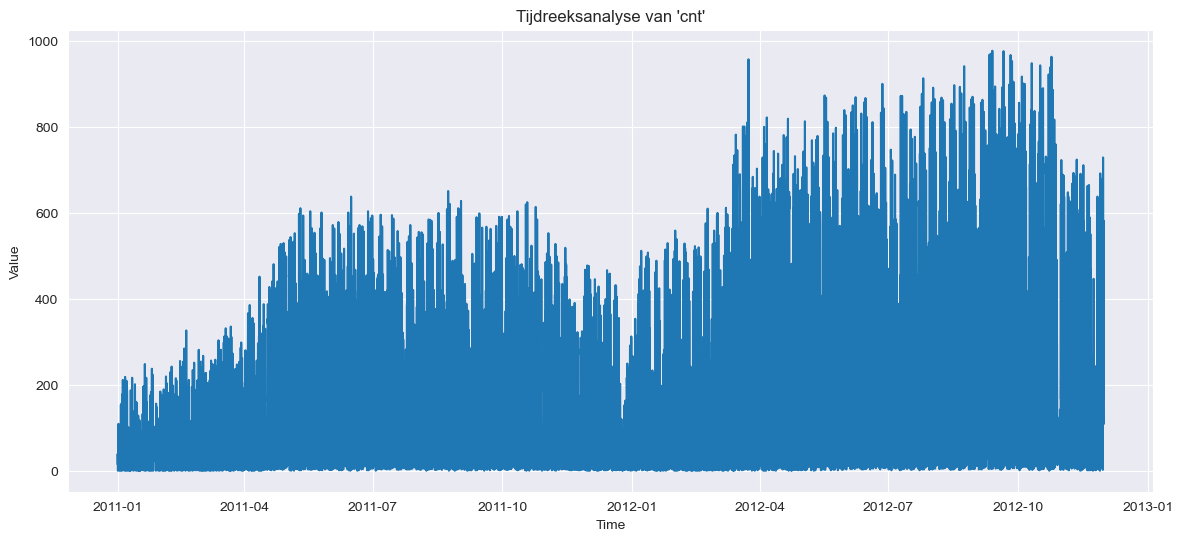

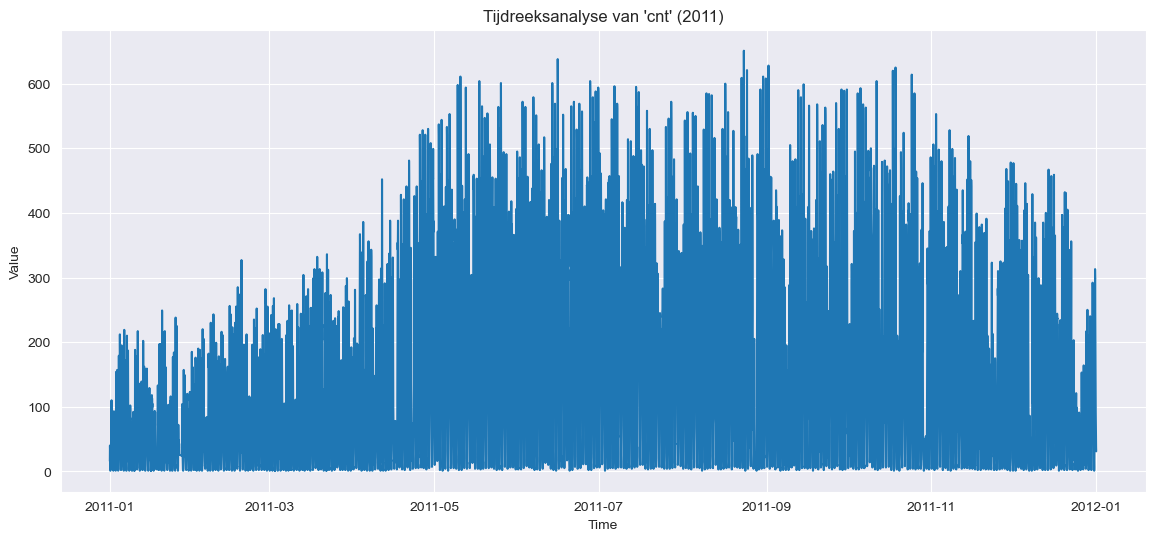

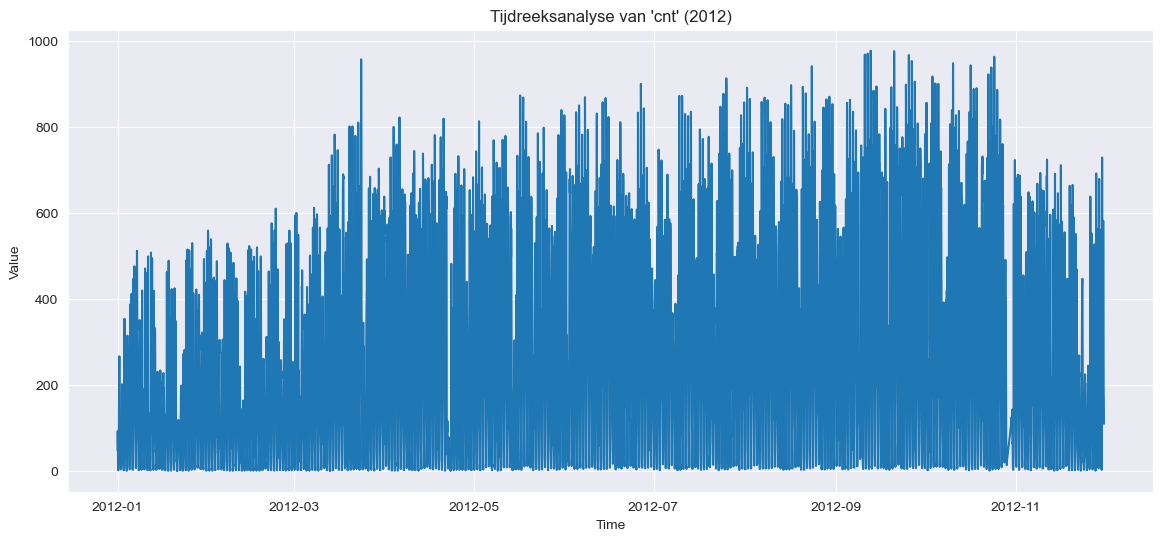

In [170]:
visualizer.plot_time_series(value_col='cnt', title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2011, title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2012, title="Tijdreeksanalyse van 'cnt'")

### Verdeling van de kolommen

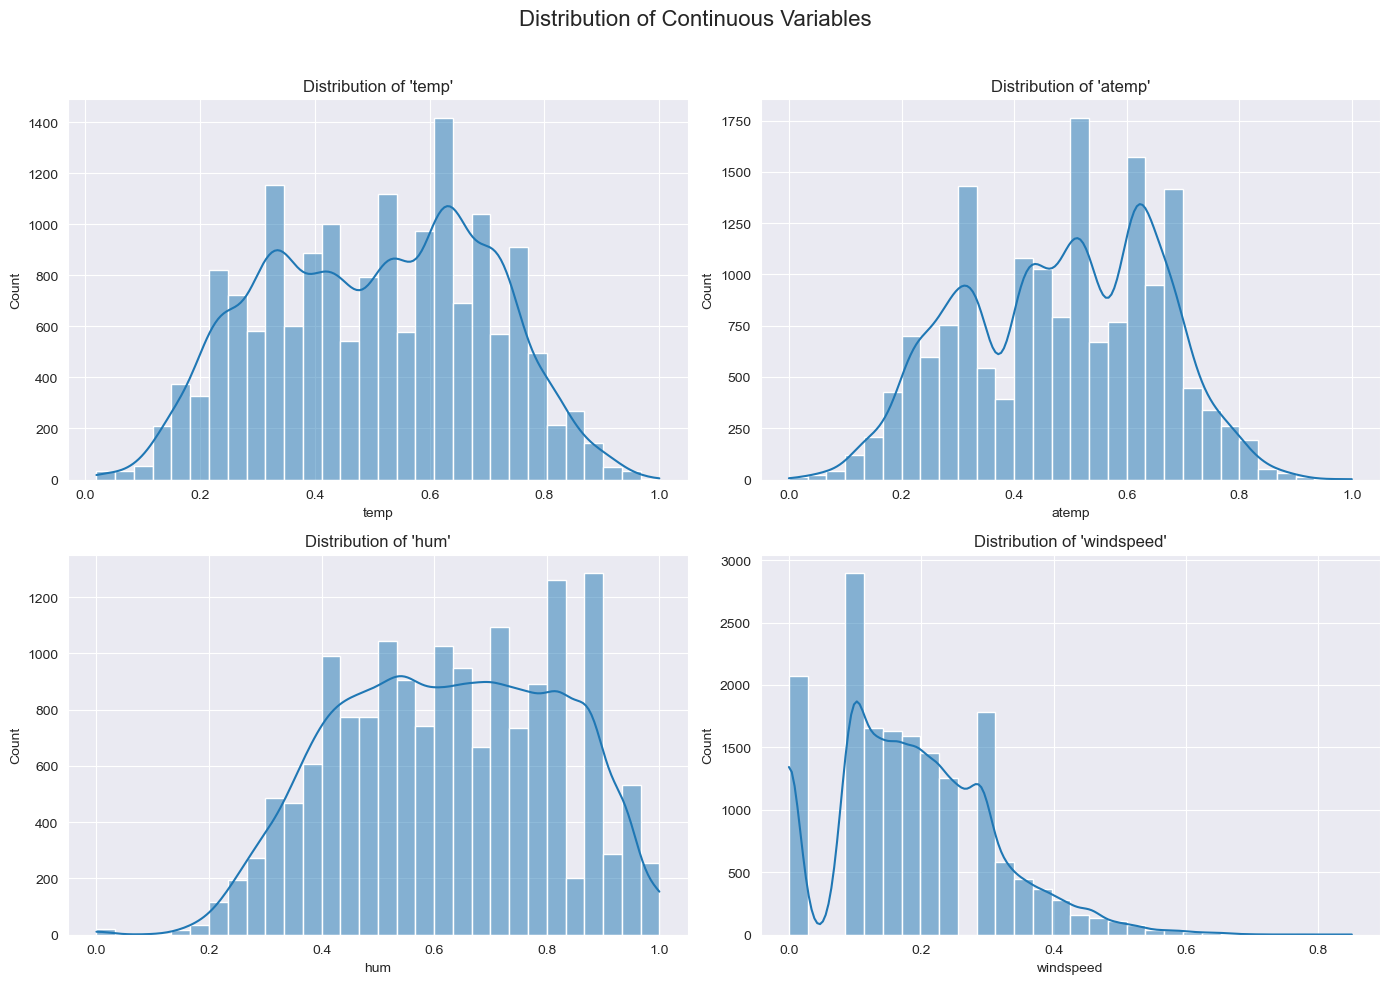

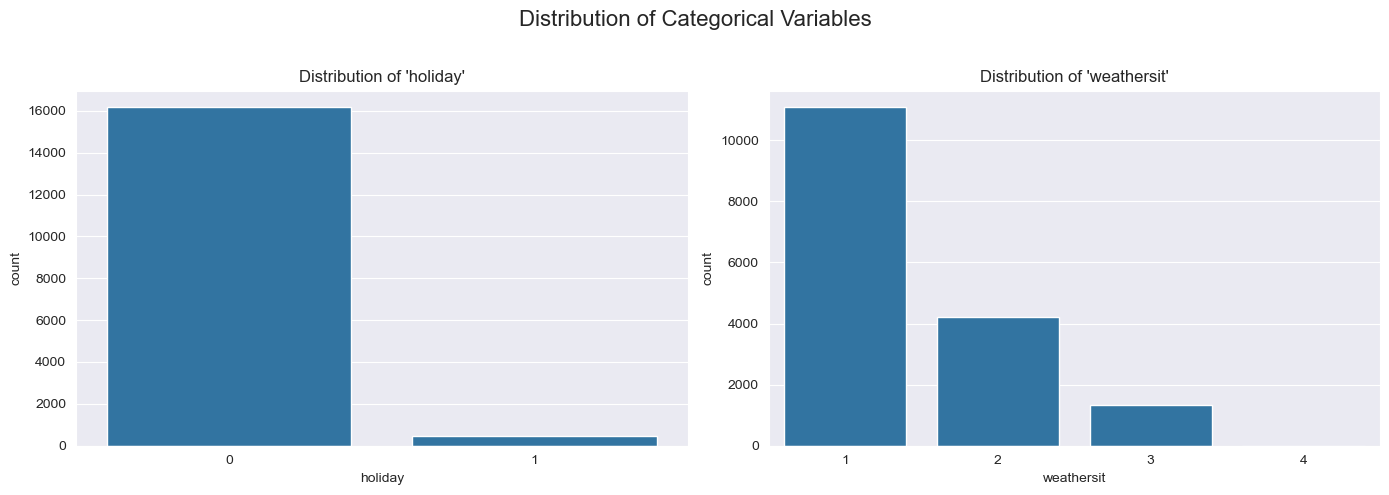

In [171]:
visualizer.plot_distributions(continuous_cols=['temp', 'atemp', 'hum', 'windspeed'])
visualizer.plot_categorical_counts(categorical_cols=['holiday', 'weathersit'])

### Relaties

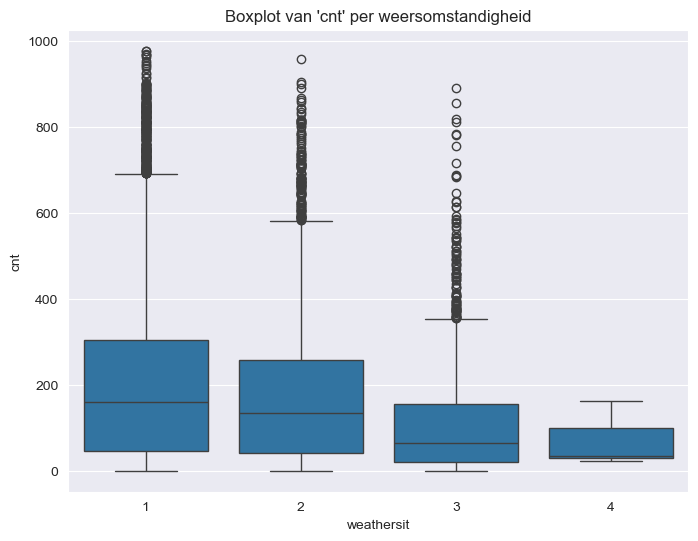

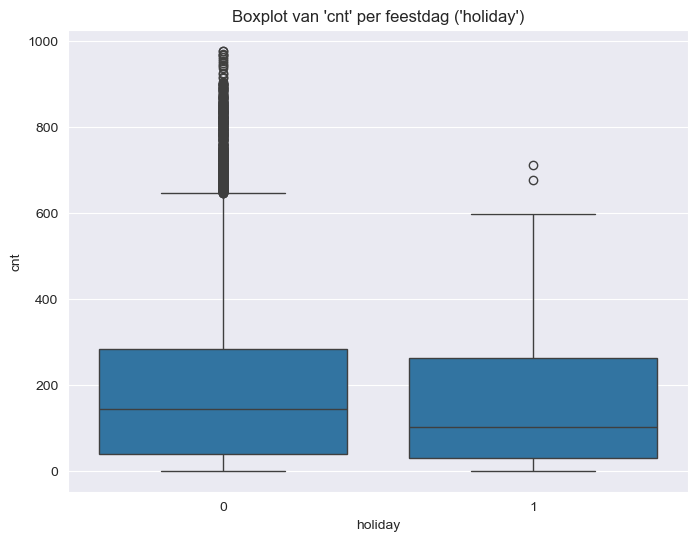

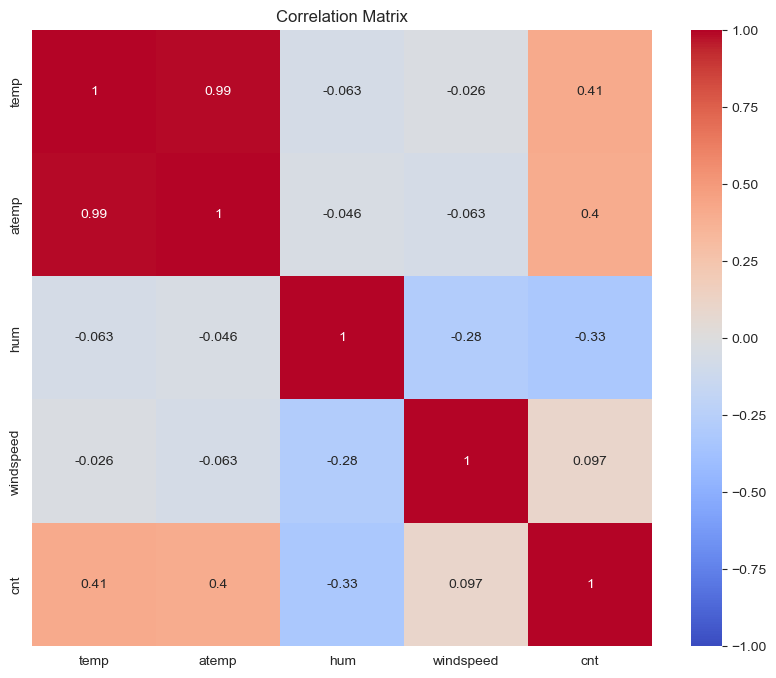

In [172]:
visualizer.plot_boxplot(x_col='weathersit', y_col='cnt', title="Boxplot van 'cnt' per weersomstandigheid")
visualizer.plot_boxplot(x_col='holiday', y_col='cnt', title="Boxplot van 'cnt' per feestdag ('holiday')")
visualizer.plot_correlation_matrix(cols=['temp', 'atemp', 'hum', 'windspeed', 'cnt'])

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.
- Er blijkt heel weinig holidays te zijn
- De verdeling bij weeromstaandigheid is er te zien dat de aantallen per waarde daalt, waarbij 1 de hoogste is. 

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.


#### Controle op Uitschieters

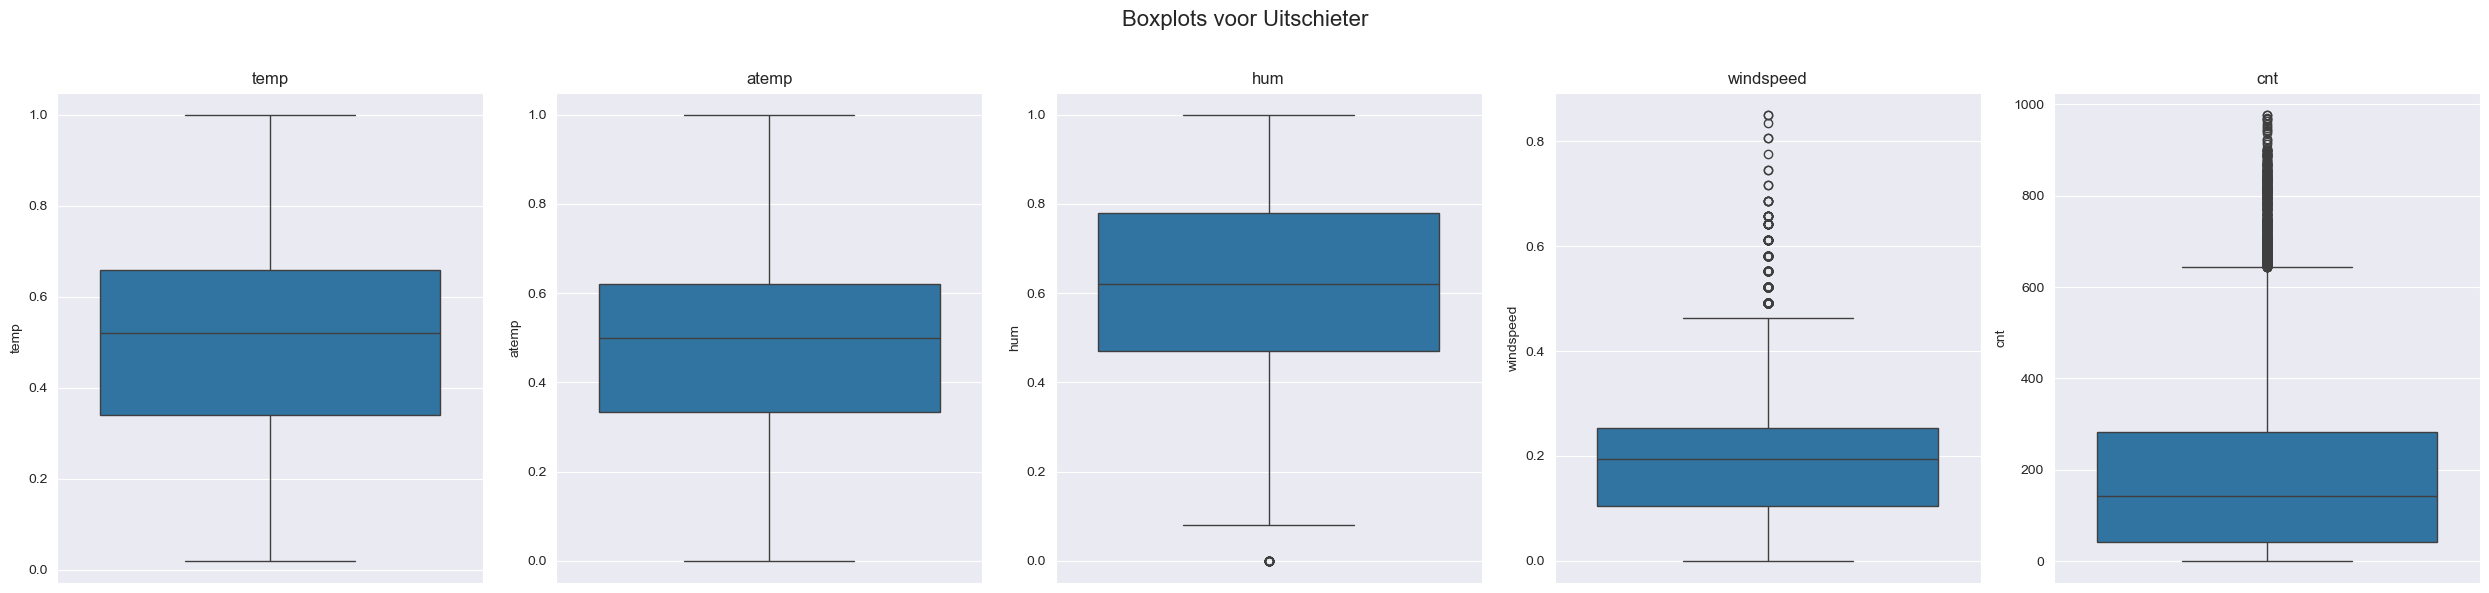

In [166]:
# Boxplots for outliers
visualizer.plot_boxplots(cols=["temp", "atemp", "hum", "windspeed", "cnt"], 
                         title="Boxplots voor Uitschieter")

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.

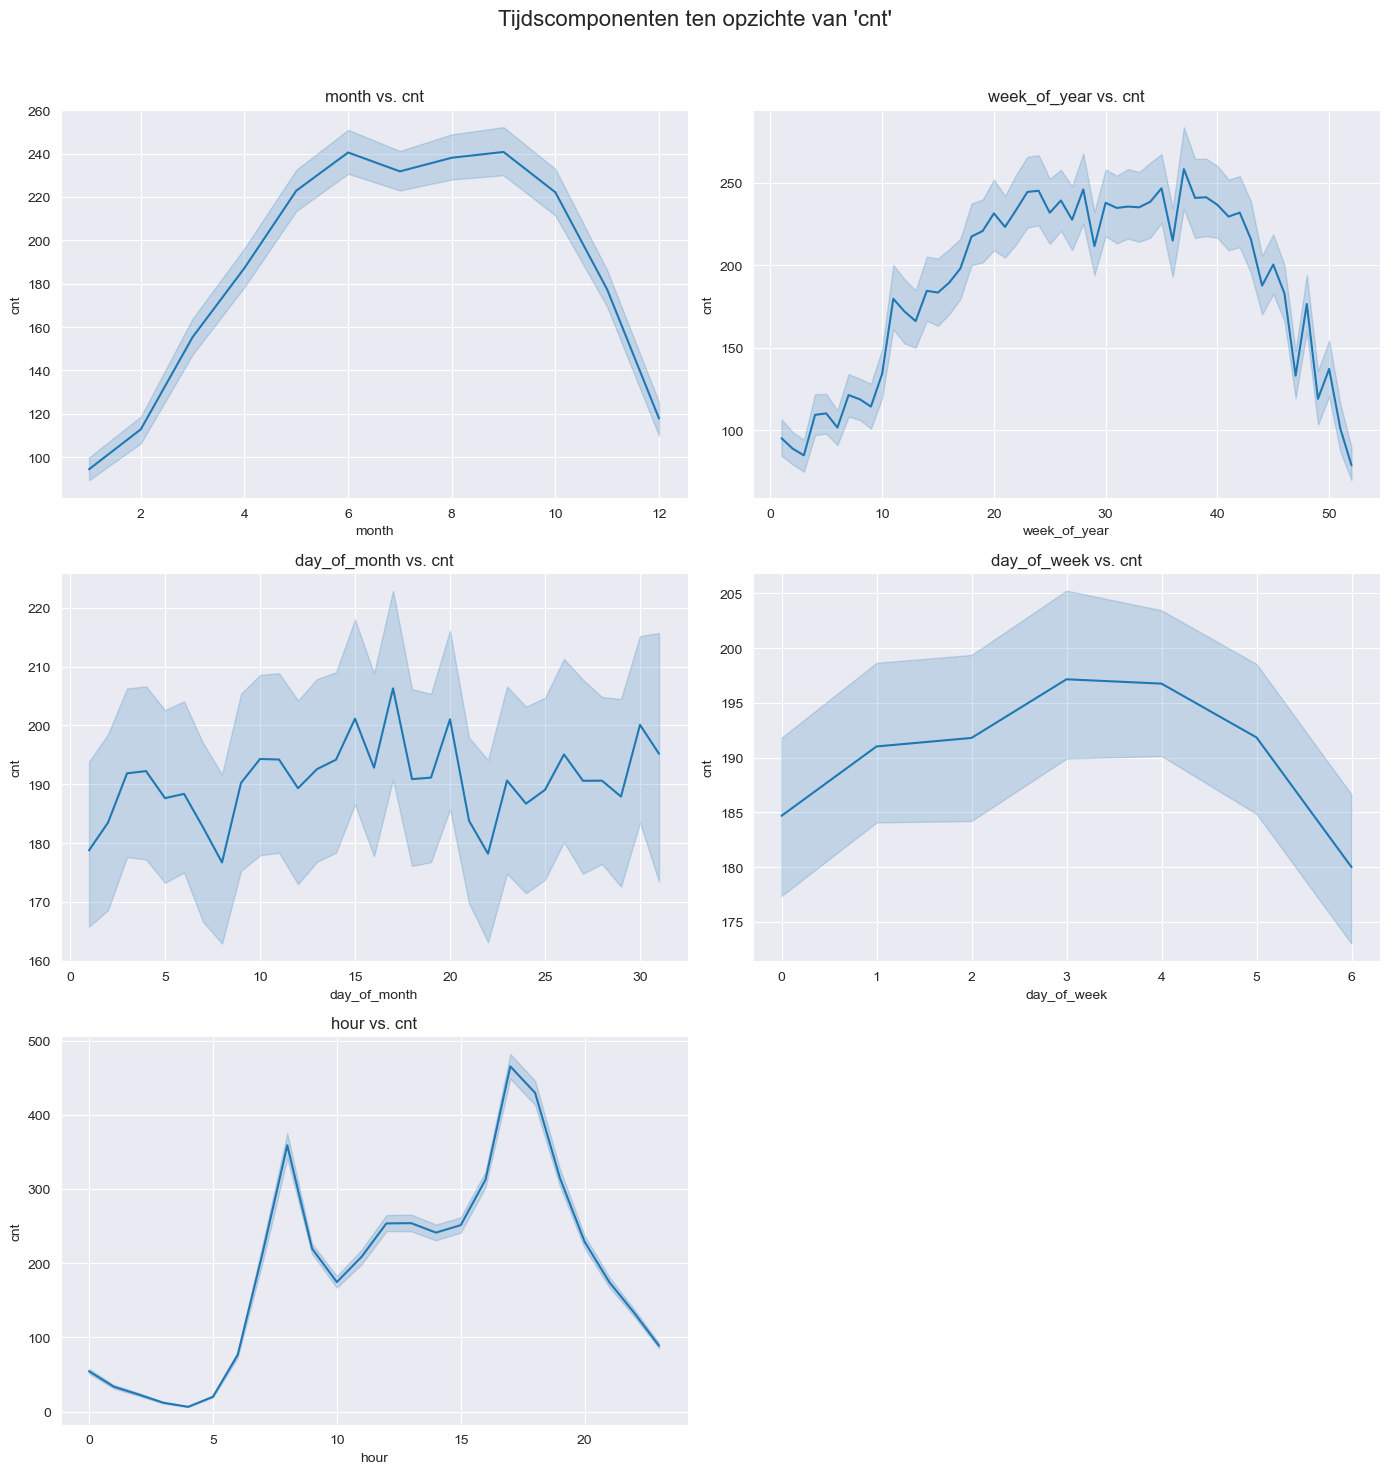

In [116]:
# Time components vs 'cnt'
visualizer.plot_time_components_vs_cnt(time_components=['month', 'week_of_year', 'day_of_month','day_of_week', 'hour'],
                                        target_col="cnt", 
                                        title="Tijdscomponenten ten opzichte van 'cnt'")

Uit de plots hierboven zien we dat het product meer verhuurd wordt in bepaalde seizoen en tijden van de dag. We zien dat de piek in de zomer en begin herfst ligt. Door de week is er geen grote verschillen in het aantal verhuurd, maar het hoogste gemiddelde zit in donderdag(3) en vrijdag(4). En het laagste is op de zondag(6). Bij hour vs cnt zien we dat er tijdens de piek uren meer wordt verhuurd.

## Feature Engineering

### Analysis

In [117]:
class time_series_analysis:
    def __init__(self, dataframe):
        self.df = dataframe

    def periodigram(self, col='cnt', xlim=None, ylim=None, filter_amp=None):
        timeserie = self.df[col]
        n = len(timeserie)
        freq = np.fft.fftfreq(n,1)
        fft_result = fft(timeserie)

        plt.figure(figsize=(10, 6))
        plt.plot(freq, np.abs(fft_result))
        plt.xlabel('Frequency (1/hour)')
        plt.ylabel('Amplitude')
        if xlim != None:
            plt.xlim([0,0.1])
        if ylim != None:
            plt.ylim([0,1e6])
        plt.title('Periodigram')
        plt.grid(True)
        plt.show()

        df_fft = pd.DataFrame(np.abs(fft_result))
        df_fft['freq'] = freq
        hours = []
        days= []
        for f in freq:
            if f != 0:
                hours.append(1/f)
                days.append(1/f/24)
            else:
                hours.append(np.inf)
                days.append(np.inf)
        df_fft['duur in uren'] = hours
        df_fft['duur in dagen'] = days
        df_fft.rename(columns={0:'amplitude'}, inplace=True)
        if filter_amp != None:
            df_fft = df_fft[(df_fft['amplitude'] > filter_amp)&(df_fft['freq'] > 0)]
        else:
            df_fft = df_fft[df_fft['freq'] > 0]
        display(df_fft)

    def plot_autocorrelations(self, col='', lags=24):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # ACF plot
        plot_acf(self.df[col], ax=axes[0], lags=lags)
        axes[0].set_title("Autocorrelation Function (ACF)")

        # PACF plot
        plot_pacf(self.df[col], ax=axes[1], lags=lags)
        axes[1].set_title("Partial Autocorrelation Function (PACF)")

        plt.tight_layout()
        plt.show()

    def plot_seasonal_decompose(self, col='', model='additive', period=24):
        sd = seasonal_decompose(self.df[col], model=model, period=period)
        plt.figure(figsize=(30,6))
        plt.title("Trend")
        sd.trend.plot()
        plt.figure(figsize=(30,6))
        plt.title("Seasonal")
        sd.seasonal.plot()
        plt.figure(figsize=(30,6))
        plt.title("Resid")
        sd.resid.plot()
        plt.show()

ts_analyzer = time_series_analysis(train)

#### Seizoenspatronen met Fourier analyse

##### Wat is Fourier analyse?
Het is een wiskundig methode dat patronen vindt binnen een genormaliseerde timeseries dataset. Het vereenvoudigt complexe data door het te veranderen naar een serie van trigonomische of exponentiele functies. Door alle complicerende factors van het dataset weg te halen kunnen patronen makkelijker herkend worden, waardoor voorspellingen maken makkelijker wordt.

[(Hayes, 2023)](https://www.investopedia.com/terms/f/fourieranalysis.asp) 

De formule van een Fourier series:
$$
f(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty}(a_k\cos(2\pi kt) + b_k\sin(2\pi kt))
$$

waar
- $\frac{a_0}{2}$ het constante term representeert,
- $a_k\cos(2\pi kt)$ en $b_k\sin(2\pi kt)$ de cosinus en sinus termen zijn,
- $k$ het harmonische frequentie is,
- $\sum_{k=1}^{\infty}$ zegt dat er een oneindig serie van sinus en cosinus functies met verschillende frequenties en amplitudes opgeteld worden, die $f(t)$ preciezer zou vinden

Een fourier analyse is het manier waarop functies benaderd kunnen worden door het combinatie van trigonometrische functies. 

[(3Blue1Brown, 2018)](https://www.youtube.com/watch?v=spUNpyF58BY )


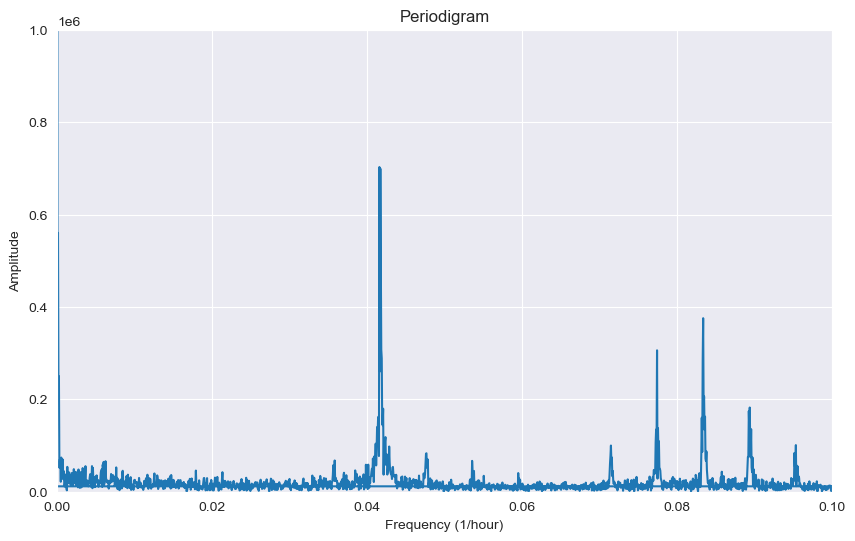

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422
696,307463.826990,0.041834,23.903736,0.995989
1288,306064.251401,0.077418,12.916925,0.538205
1387,375575.609672,0.083368,11.994953,0.499790


In [118]:
ts_analyzer.periodigram(xlim=[0,0.1], ylim=[0,1e6], filter_amp=0.3e+06)

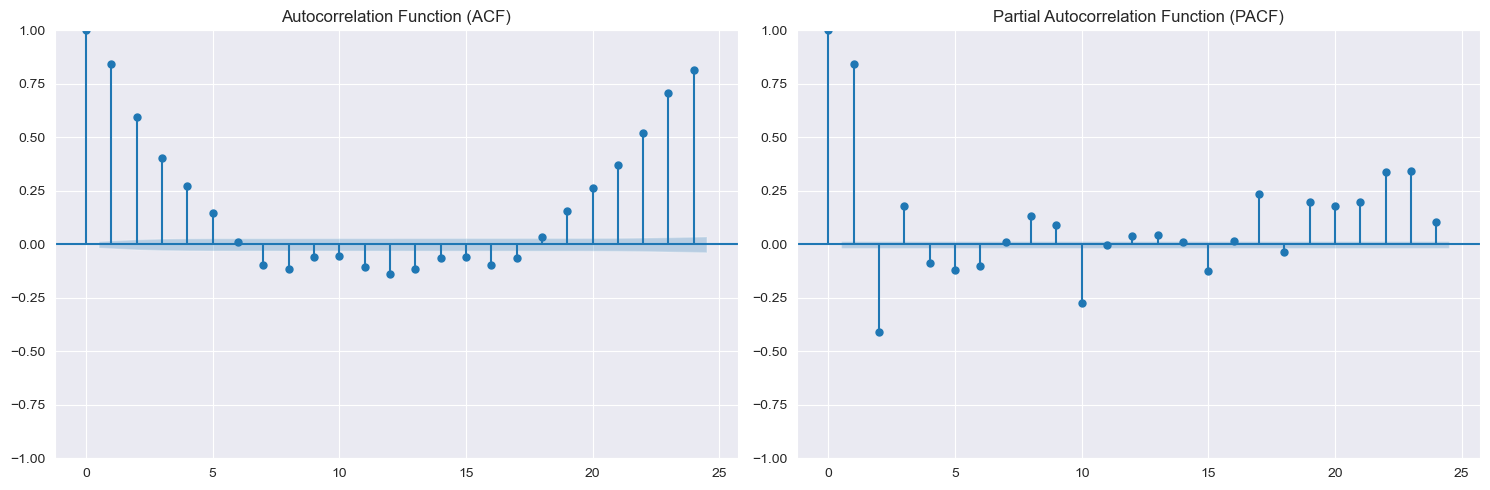

In [119]:
ts_analyzer.plot_autocorrelations(col='cnt', lags=24)

In de visualisaties is het te zien dat de target variabele begint toe te nemen rond april, en afneemt rond de wintermaanden, beginnend met november.

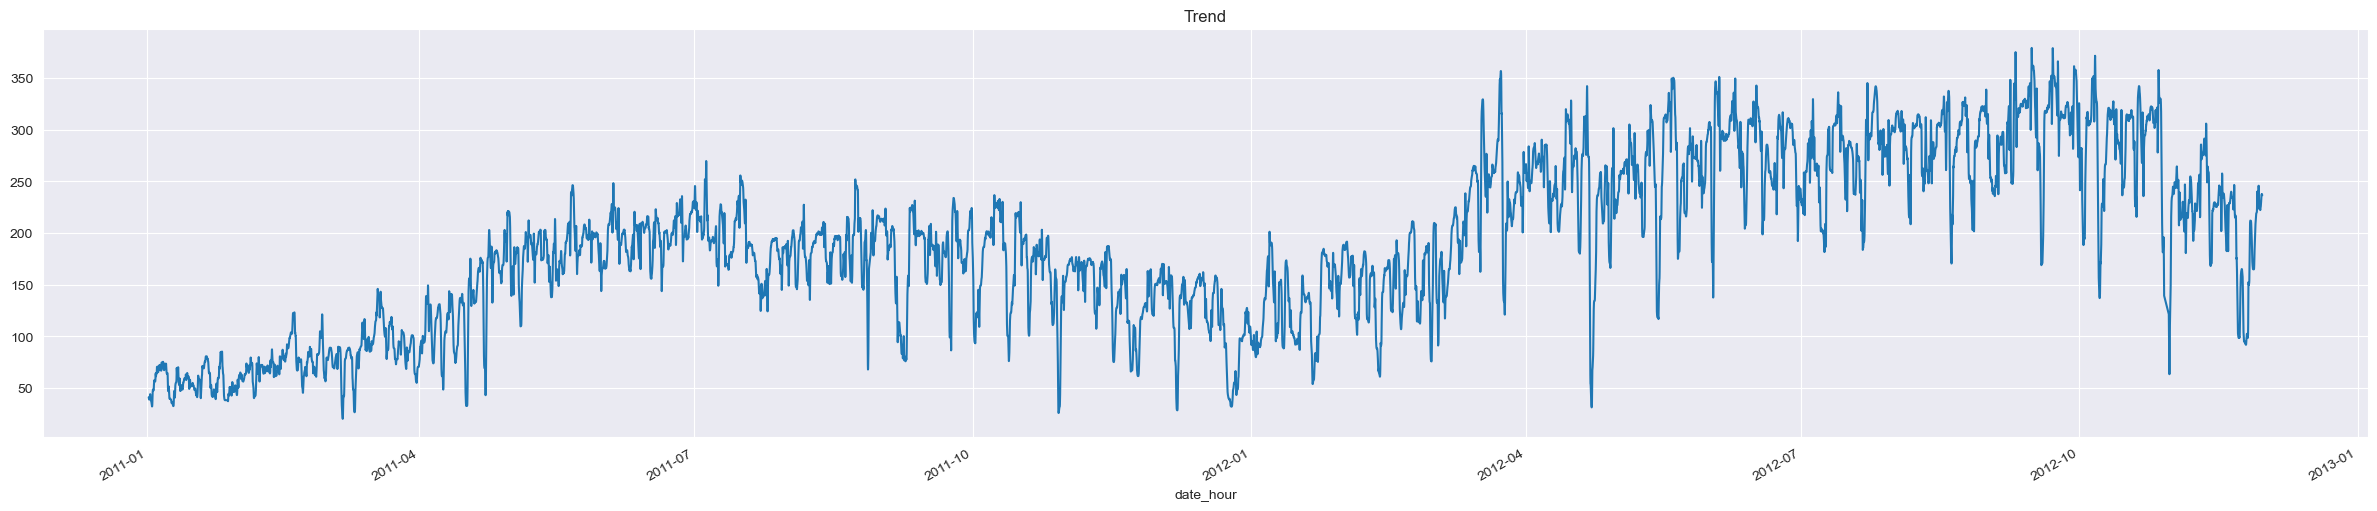

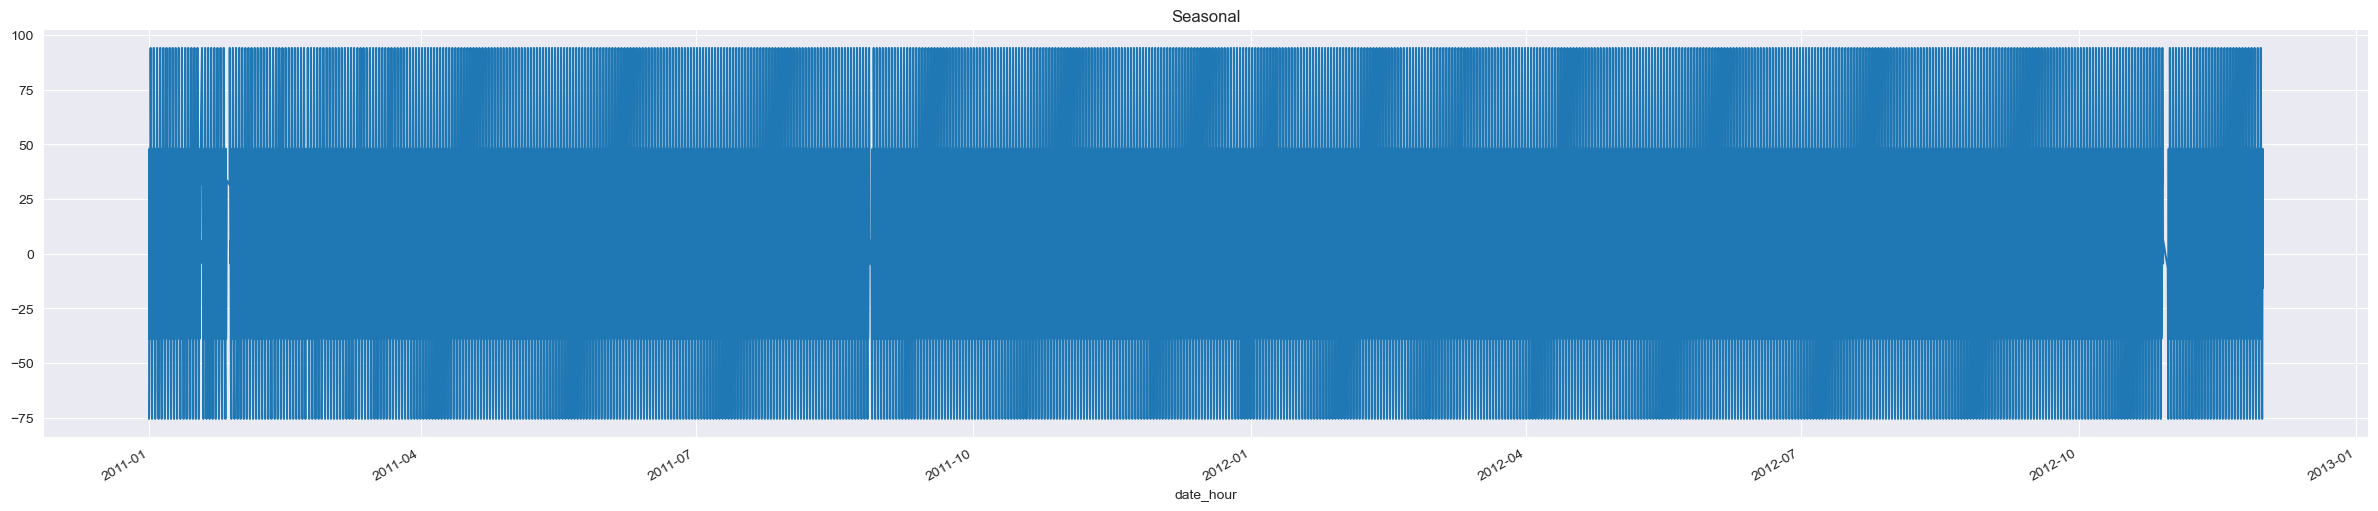

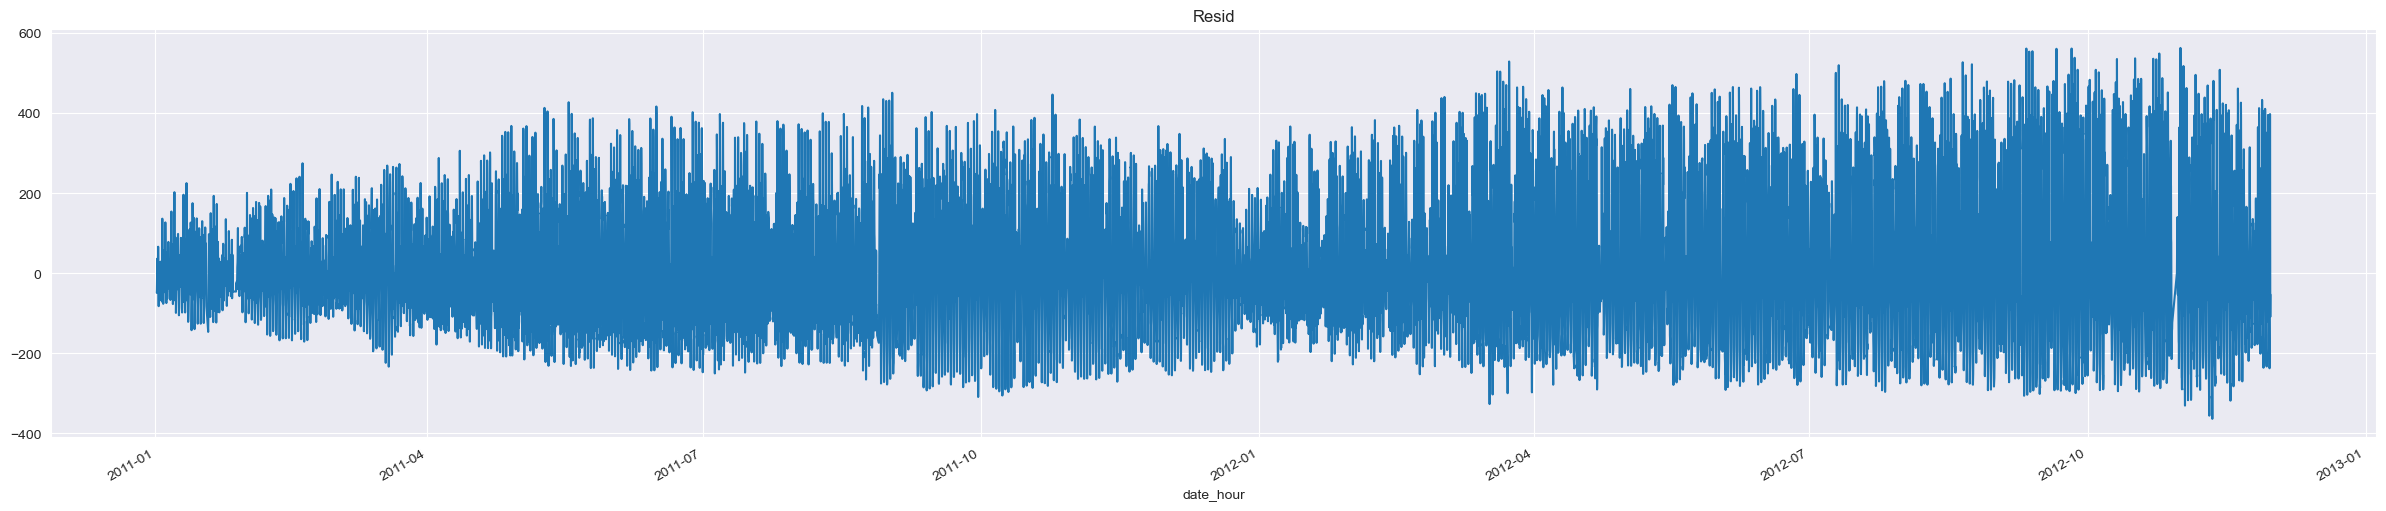

In [120]:
ts_analyzer.plot_seasonal_decompose(col='cnt', model='additive', period=24)

Onderzoek naar trends

Na een Fourier analyse uit te voeren op de data, is het te zien dat de grootste trends jaarlijks en dagelijks zijn. De jaarlijkse trends zou in dit geval groei van het populariteit van het product over tijd kunnen zijn, dit ligt aan het feit dat de jaarlijkse piek in 2011 lager is dan die van 2012.

De dagelijkse trend kan liggen aan andere variabelen, zoals temperatuur, weeromstandigheden of vakantie.

### Time Series Feature Engineering

In [255]:
data

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,52,1,1,5,0
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,52,1,1,5,1
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,52,1,1,5,2
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,52,1,1,5,3
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,52,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,48,335,30,4,19
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,48,335,30,4,20
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,48,335,30,4,21


In [ ]:
class time_series_feature_engineering:
    def __init__(self, train, test, target=''):
        # Ensure the dataframe has a datetime index
        if not isinstance(train.index, pd.DatetimeIndex):
            raise ValueError("The train dataframe index must be a DatetimeIndex.")
        if not isinstance(test.index, pd.DatetimeIndex):
            raise ValueError("The test dataframe index must be a DatetimeIndex.")
        
        self.df = train.copy()
        self.X_train = self.df.drop(target, axis=1)
        self.y_train = self.df[target]
        self.test = test.copy()

        # Generate features for train data
        self.X_train['year'] = self.X_train.index.year
        self.X_train['month'] = self.X_train.index.month
        self.X_train['week_of_year'] = self.X_train.index.isocalendar().week
        self.X_train['week_of_year'] = self.X_train['week_of_year'].astype('int32')
        self.X_train['day_of_year'] = self.X_train.index.day_of_year
        self.X_train['day_of_month'] = self.X_train.index.day
        self.X_train['day_of_week'] = self.X_train.index.weekday  # 0=Monday, 6=Sunday
        self.X_train['hour'] = self.X_train.index.hour
        self.X_train['is_weekend'] = self.X_train.index.weekday >= 5  # Boolean feature for weekends
        self.X_train['season'] = self.X_train['month'].apply(self.get_season)
        self.X_train['day_name'] = self.X_train.index.day_name()
        self.X_train = pd.get_dummies(self.X_train, columns=['season','day_name','weathersit'], prefix=['season','day_name','weathersit'])
        
        # Generate features for test data
        self.test['year'] = self.test.index.year
        self.test['month'] = self.test.index.month
        self.test['week_of_year'] = self.test.index.isocalendar().week
        self.test['week_of_year'] = self.test['week_of_year'].astype('int32')
        self.test['day_of_year'] = self.test.index.day_of_year
        self.test['day_of_month'] = self.test.index.day
        self.test['day_of_week'] = self.test.index.weekday
        self.test['hour'] = self.test.index.hour
        self.test['is_weekend'] = self.test.index.weekday >= 5
        self.test['season'] = self.test['month'].apply(self.get_season)
        self.test['day_name'] = self.test.index.day_name()
        self.test = pd.get_dummies(self.test, columns=['season','day_name','weathersit'], prefix=['season','day_name','weathersit'])

        # Align test and train columns
        self.X_train, self.test = self.X_train.align(self.test, join='left', axis=1, fill_value=0)

        self.X_train = self.X_train.astype({col: 'int' for col in self.X_train.select_dtypes(include='bool').columns})
        self.test = self.test.astype({col: 'int' for col in self.test.select_dtypes(include='bool').columns})

        # Check for missing values and warn
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

    def get_season(self, month):
        """Returns the season for a given month."""
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'

    def check_missing_values(self, df, name):
        """Check for missing values and print a warning if any are found."""
        missing_values = df.isnull().sum()
        if missing_values.any():
            print(f"Warning: Missing values found in {name}:")
            print(missing_values[missing_values > 0])

    def add_fourier_feature(self, freqs, order, constant=False, seasonal=False, drop=True):  
        # Ensure freqs is a list
        if not isinstance(freqs, list):
            freqs = [freqs]  # If a single freq is provided, make it a list

        fourier_terms = []
        for freq in freqs:
            fourier_terms.append(CalendarFourier(freq=freq, order=order))

        dp = DeterministicProcess(index=self.X_train.index, constant=constant, order=order, seasonal=seasonal,
                                        additional_terms=fourier_terms, drop=drop)
            
        X_train2 = dp.in_sample()
        test2 = dp.out_of_sample(steps=len(self.test), forecast_index=self.test.index)

        self.X_train = pd.concat([self.X_train, X_train2], axis=1)
        self.test = pd.concat([self.test, test2], axis=1)

        # Check for missing values after adding Fourier features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")
    
    def lag_feature(self, column='', lags=int):
        """
        Creates lag features for a given column in the training and test datasets.
        
        Args:
            column (str): The column to create lag features for.
            lags (list or int or range): A list, range, or single integer specifying the lag values.
        """
        if isinstance(lags, int):  # If a single integer is provided
            lags = [lags]
        elif isinstance(lags, range):  # If a range is provided
            lags = list(lags)
        
        for lag in lags:
            self.X_train[f'{column}_lag_{lag}'] = self.X_train[column].shift(lag)
            self.test[f'{column}_lag_{lag}'] = self.test[column].shift(lag)

        # Ensure rows with missing lag values are handled properly in both datasets
        self.X_train = self.X_train.fillna(0)
        self.test = self.test.fillna(0)

        # Check for missing values after creating lag features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

ts_fe = time_series_feature_engineering(train, test, target='cnt')

In [257]:
ts_fe.add_fourier_feature(freqs=['YE','D'], order=1)

Voor het kiezen van de features willen we zo veel mogelijk informatie uit de datetime data halen en beginnen we met de basis informatie (year, month, week of year). Verder zijn er 3 typen 'day' data, nl: day of year, day of month en day of week. En dan hebben we de 'hour'. We hebben met XGBoostRegressor gewerkt om de scores elke keer te vergelijken, als het beter of slechter wordt. Bij de EDA zijn er grafieken geplot met de tijdscomonenten vs 'cnt' (Tijdscomponenten ten opzichte van 'cnt'), en we zagen dat er pieken zijn bij bepaalde seizoenen. Vandaar we 'season' hebben toegevoegd. 'is_weekend' en 'day_name' zijn extra informatie die we hebben toegevoegd en hebben 'season', 'day_name' en 'weathersit' dummies van gemaakt voor meer informatie voor de modellen.

In [262]:
display(ts_fe.X_train.head(10), ts_fe.test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,2011,1,52,1,1,5,0
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,1
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,2
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,3
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,4
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,2011,1,52,1,1,5,5
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,6
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,2011,1,52,1,1,5,7
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,8


,holiday,weathersit,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,0
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,1
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,2
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,2012,12,48,336,1,5,3
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,2012,12,48,336,1,5,4
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896,2012,12,48,336,1,5,5
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,6
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,7
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,8


## Modeling

In [263]:
X_train = ts_fe.X_train.copy()
y_train = ts_fe.y_train.copy()

In [264]:
rf = RandomForestRegressor().fit(X_train, y_train)
score = -cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(score)

57.23763848396567


In [265]:
xgb_model = XGBRegressor(n_estimators=1750, max_depth=5, learning_rate=0.045, colsample_bytree=0.5, gamma=2, min_child_weight=2, objective='reg:squarederror', subsample=0.7)
xgb_model.fit(X_train, y_train)

xgb_score = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("XGBoost CV Score:", xgb_score)

XGBoost CV Score: 52.66833008618097


### K-Nearest Neighbors Regression

De KNN algoritme is een techniek die zich richt op de waardes rond een bepaald punt. Die punt wordt dan geclassificeerd op basis van het aantal ingestelde 'nearest neighbors', oftewel naaste buren. Als je dan instelt dat je de 5 'nearest neighbors' kiest, dan wordt de waarde geclassificeerd als de meerderheid van die buren. 

[(IBM, 2024)](https://www.ibm.com/topics/knn)

KNN Regression is een eenvoudig algoritme dat gebaseerd is op het afstand van een punt tot een bepaald aantal dichtbijzijnde punten (K). Het afstand kan op een aantal verschillende manieren gemeten worden. Ten opzichte van KNN-classificatie, in KNN-regressie is de voorspelde waarde van de datapunt gelijk aan de gemiddelde van de dichtbijzijnde punten 
(target-waardes).

[(Singh, 2024)](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/#How_Does_the_KNN_Algorithm_Work?)

De afstand naar de gekozen punt wordt meestal berekent met de manhattan- of euclidean-methode. De **Euclidean** methode berekent een rechte lijn tussen de gekozen punt en een 'buur'. Euclidean afstand bereken je met de volgende formule:

$$
d(x, y) = \sqrt{\sum_{i=1}^{n} (y_i - x_i)^2}
$$

De **Manhattan** methode kiest voor het meten van de absolute waarde van het verschil tussen twee punten. De naam komt van de visualisatie die vaak met dit methode komt, omdat het als een rooster uitziet, net alsof je Manhattan van boven ziet. De Manhattan afstand kun je berekenen met dit methode:

$$
d(x, y) = (\sum_{i=1}^{m} |x_i - y_i|)
$$

[(IBM, 2024)](https://www.ibm.com/topics/knn)

**Standardisatie**

De manier waarop KNN beslissingen neemt heeft veel te maken met het afstand tussen waardes, waardoor de schaal veel invloed heeft op de afstandsbepaling. Door de waardes te standardiseren, voorkom je dat sommige features meer voorkomen.

[(Goedegebuure, 2021)](https://bookdown.org/robert_statmind/mmsc_test_01/the-k-nn-algorithm.html#standardizing-data)

**Hyperparameters**

De belangrijkste hyperparameter bij KNN is de het aantal buren (k). Een grotere k-waarde geeft een eenvoudige decision-boundary en vermindert overfitting, maar is niet handig met alle datasets. Een kleinere k-waarde kan er juist voor zorgen dat er sprake is van overfitting. 

[(Abdallah, 2023)](https://www.linkedin.com/pulse/improve-model-hyperparameter-tuning-k-nearest-muctary-abdallah-1e)


In [35]:
# Daadwerkelijke KNN model

knn_model = KNeighborsRegressor(n_neighbors=3, weights='distance', metric='manhattan')
knn_model.fit(X_train, y_train)

knn_score = -cross_val_score(knn_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"KNN score: {knn_score}")

KNN score: 151.1262644635267


In [36]:
# Beste parameters

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_model = KNeighborsRegressor()
knn_gridsearch = GridSearchCV(knn_model, knn_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
knn_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for KNN:", knn_gridsearch.best_params_)

knn_tuned = knn_gridsearch.best_estimator_
knn_score = -cross_val_score(knn_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("KNN CV Score:", knn_score)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
KNN CV Score: 147.75476670517878


### **Lineaire Regressie**

Lineaire regressie is een wiskundige methode die gebruikt wordt om de relatie tussen twee variabelen te beschrijven met een rechte lijn. Deze lijn heeft de volgende vergelijking:
[(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

$$y=a⋅x+b$$

Waarbij:

- $y$:  De afhankelijke variabele.
- $x$: De onafhankelijke variabele.
- $a$: De helling van de lijn, die laat zien hoe $y$ verandert als $x$ toeneemt.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Bij meer complexe datasets met meerdere onafhankelijke variabelen wordt de formule uitgebreid naar een multivariate vorm:

$$
y = a_1 \cdot x_1 + a_2 \cdot x_2 + \dots + a_n \cdot x_n + b
$$

Waarbij:

- $x_1, x_2, \dots, x_n$: De onafhankelijke variabelen.
- $a_1, a_2, \dots, a_n$: De hellingen.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Dit wordt vaak gebruikt in **meervoudige lineaire regressie** [(Tieleman (2023))](https://datasciencepartners.nl/linear-regression-assumptions/).

Het doel van lineaire regressie is om een verband te laten zien tussen twee soorten gegevens: een onafhankelijke variabele en een afhankelijke variabele. Dit gebeurt door een rechte lijn te maken die zo goed mogelijk bij de gegevens past. De lijn wordt zo gekozen dat het verschil tussen de echte waarden en de voorspelde waarden zo klein mogelijk is. Op deze manier laat de lijn zien hoe de gegevens samenhangen en wat de trend is.

#### **De Kleinste Kwadraten Methode(The Least Squares Method)**
De kleinste kwadraten methode berekent de lijn die de data het best past door de residuen te minimaliseren. Een residu is het verschil tussen de werkelijke waarde ($y_i$) en de voorspelde waarde ($y=a⋅x+b$). Deze verschillen worden gekwadrateerd en opgeteld, zoals weergegeven in de formule:

$$RSS=\sum_{i=1}^{n} \left( y_i - (a \cdot x_i + b) \right)^2$$


De lijn die ervoor zorgt dat de totale afwijking zo klein mogelijk is, wordt de beste lijn genoemd.

[(Wikipedia contributors, 2023)](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

De helling ($a$) wordt berekend met:

$$
a = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}
$$

[(Statistiek en Kansrekening 6.6: Regressie - Uitleg, z.d.)](https://info.math4all.nl/MathAdore/vd-b66-ep1.html)

En het snijpunt ($b$) wordt berekend met:

$$
b = \bar{y} - a \cdot \bar{x}
$$


Waarbij:


- $\bar{x}$: Het gemiddelde van alle $x_i$-waarden.
- $\bar{y}$: Het gemiddelde van alle $y_i$-waarden.
- $(x_i - \bar{x})$: Het verschil van $x_i$ ten opzichte van het gemiddelde.
- $(y_i - \bar{y})$: Het verschil van $y_i$​ ten opzichte van het gemiddelde.


Deze formules helpen om de regressielijn zo te maken dat de relatie tussen $x$ en $y$ zo goed mogelijk wordt weergegeven.

[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Ordinary_least_squares)

#### **Loss Function**

De loss-functie is een wiskundige manier om te meten hoe goed of slecht een model voorspellingen maakt. Bij lineaire regressie kijkt de loss-functie naar het verschil tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Het doel is om dit verschil zo klein mogelijk te maken. Tijdens het trainen van het model wordt de loss-functie geminimaliseerd, zodat het model zo nauwkeurig mogelijk wordt.

**Mean Squared Error (MSE):**

De MSE wordt berekend als:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

Waarbij:

- $n$: Het aantal datapunten in de dataset.
- $y_i$: De werkelijke waarde van $y$.
- $\hat{y}_i$: De voorspelde waarde van $y$.
- $\left( y_i - \hat{y}_i \right)$: Het residu, oftewel het verschil tussen de werkelijke en voorspelde waarde.

MSE berekent het gemiddelde van de gekwadrateerde verschillen tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Door de fouten te kwadrateren, krijgen grotere afwijkingen meer invloed. Hierdoor is MSE gevoelig voor uitschieters.

**root Mean Squared error (RMSE)**

De MSE wordt berekend als:

$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

RMSE is de wortel van de gemiddelde kwadratische fout (MSE) en brengt de fouten terug naar dezelfde schaal als de doelwaarden.

[(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)

**Mean Absolute Error (MAE)**

De MAE wordt berekend als:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$


- $\left| y_i - \hat{y}_i \right|$: Absolute waarde van de fout.


MAE berekent het gemiddelde van de absolute verschillen tussen de echte waarden en de voorspelde waarden. Omdat de fouten niet worden gekwadrateerd, is MAE minder gevoelig voor uitschieters dan MSE.

 [(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)
 [(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

**Huber Loss**

De Huber Loss is een combinatie van MSE en MAE en wordt gedefinieerd als:

$$
\text{Huber Loss} = 
\begin{cases} 
\frac{1}{2} (y_i - \hat{y}_i)^2 & \text{als } |y_i - \hat{y}_i| \leq \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2} \delta^2 & \text{anders}
\end{cases}
$$

- $δ$: Drempelwaarde die bepaalt wanneer MSE wordt gebruikt en wanneer MAE.

Huber Loss is kwadratisch voor kleine fouten (zoals MSE) en lineair voor grote fouten (zoals MAE). Dit maakt het minder gevoelig voor uitschieters, terwijl het nog steeds de voordelen van beide methoden behoudt.

[(GeeksforGeeks (2024))](https://www.geeksforgeeks.org/loss-function-for-linear-regression/)

#### **Metrics**

$R$ is de correlatiecoëfficiënt en laat zien hoe sterk de lineaire relatie is tussen twee variabelen ($x$ en $y$). De waarde van $R$ ligt tussen -1 en 1.

$$R = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$

waarbij:
- $(x_i)$ en $(y_i)$ de verschillende waarden van de variabelen $x$ en  $y$ zijn.
- $\bar{x}$ en $\bar{y}$ de gemiddelden van de variabelen $x$ en  $y$ zijn.

Interpretatie van $R$:
- $R=1:$ Perfect positieve correlatie.
- $R=−1:$ Perfect negatieve correlatie.
- $R=0:$ Geen lineaire correlatie.

[(Hashmi (2022))](https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9)

$R^2$ De coëfficiënt van determinatie laat zien hoe goed de onafhankelijke variabelen de afhankelijke variabele kunnen voorspellen. De formule is:

$$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

$R2$ is het kwadraat van $R$. Dit betekent dat $R2$ altijd een positieve waarde heeft, terwijl $R$ zowel positief als negatief kan zijn.

waarbij:
- $y_i$: De werkelijke waarden.
- $\hat{y}_i$: De voorspelde waarden.
- $\bar{y}$: Het gemiddelde van de waarden.

Interpretatie van $R^2$:

- $R^2$=1: Het model verklaart alle variatie in $y$.
- $R^2$=0: Het model verklaart geen enkele variatie.

[(Gupta (2021))](https://medium.com/analytics-vidhya/r-squared-formula-explanation-6dc0096ce3ba)
[(Turney (2023))](https://www.scribbr.nl/statistiek/determinatiecoefficient/)


#### **Regularisatie**


Regularisatie helpt om overfitting te voorkomen door een strafterm toe te voegen aan de loss function.Er zijn twee belangrijke soorten:

- L1-regularisatie (Lasso):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 

Hier wordt de som van de absolute waarden van de coëfficiënten gestraft.

L1-regularisatie zorgt ervoor dat sommige coëfficiënten precies nul worden, waardoor het model eenvoudiger wordt met minder variabelen. Dit is handig als je denkt dat sommige kenmerken niet belangrijk zijn en verwijderd moeten worden.

- L2-regularisatie (Ridge):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$

Hier wordt de som van de kwadraten van de coëfficiënten gestraft.

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 


L2-regularisatie voegt een straf toe voor grote coëfficiënten, waardoor het model eenvoudiger wordt en minder gevoelig is voor veranderingen in de data. Dit helpt om overfitting te voorkomen.

[(Nagpal (2024))](https://builtin.com/data-science/l2-regularization)


- Elastic Net

$$
\text{Loss} = \text{lossfunctie} + \lambda_1 \sum |β_i| + \lambda_2 \sum β_i^2
$$


Waarbij:

- $β$ een parameter is die de verhouding tussen L1 en L2 bepaalt. Als $β=1$, is het puur L1 en als $β=0$, is het puur L2.
- $λ$ is de reguliere hyperparameter.

Elastic Net combineert de voordelen van zowel L1 als L2: het kan coëfficiënten naar nul brengen en tegelijkertijd de coëfficiënten reguleren. Het werkt goed wanneer er veel kenmerken zijn die met elkaar correleren.
[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Elastic_net_regularization) [(Datacamp, 2019)](https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net)

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Cross-validation met 10 vouwen
lr_score = -cross_val_score(
    lr,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
).mean()

print("Modelresultaten:")
print(f"Intercept (b0): {lr.intercept_:.2f}")  # Geen indexering nodig
print(f"Coefficients (b1): {lr.coef_[0]:.2f}")  # Enkel de eerste waarde uit de array
print(f"LR score: {lr_score}")

Modelresultaten:
Intercept (b0): -149736.55
Coefficients (b1): -34.90
LR score: 139.29911373261672


In [38]:
lr_params = {
    "copy_X": [True, False],
    "fit_intercept": [True, False],
    "n_jobs": [-1, 1, 5, 10, 15, None],
    "positive": [True, False],
}


lr_model = LinearRegression()

lr_grid_search = GridSearchCV(
    lr_model, lr_params, cv=10, scoring="neg_mean_squared_error", verbose=1
)

lr_grid_search.fit(X_train, y_train)
lr_tuned = lr_grid_search.best_estimator_

lr_score = -cross_val_score(
    lr_tuned,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=10,
    n_jobs=-1
).mean()

print(f"Best Parameters: {lr_grid_search.best_params_}")
print("Modelresultaten:")
print(f"Intercept (b0): {lr_tuned.intercept_:.2f}")
print(f"Coefficients (b1): {lr_tuned.coef_[0]:.2f}")
print(f"LR score: {lr_score}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
Modelresultaten:
Intercept (b0): 0.00
Coefficients (b1): -27.94
LR score: 126.59657456036481


c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
84 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\sklearn\linear_model\_base.py", lin

In [39]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score

# Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
best_ridge = ridge_grid_search.best_estimator_

ridge_score = -cross_val_score(best_ridge, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Ridge Parameters: {ridge_grid_search.best_params_}")
print(f"Ridge Regression CV Score: {ridge_score}")

# Lasso Regression
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
best_lasso = lasso_grid_search.best_estimator_

lasso_score = -cross_val_score(best_lasso, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Lasso Parameters: {lasso_grid_search.best_params_}")
print(f"Lasso Regression CV Score: {lasso_score}")

# Elastic Net
elastic_net_params = {'alpha': [0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.5, 0.9, 1.0]}
elastic_net = ElasticNet()
elastic_net_grid_search = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
elastic_net_grid_search.fit(X_train, y_train)
best_elastic_net = elastic_net_grid_search.best_estimator_

elastic_net_score = -cross_val_score(best_elastic_net, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Elastic Net Parameters: {elastic_net_grid_search.best_params_}")
print(f"Elastic Net Regression CV Score: {elastic_net_score}")

Best Ridge Parameters: {'alpha': 100.0}
Ridge Regression CV Score: 125.38787930233752
Best Lasso Parameters: {'alpha': 0.1}
Lasso Regression CV Score: 125.57792698549186
Best Elastic Net Parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Elastic Net Regression CV Score: 125.26765581384116


[(GeeksforGeeks (2024a))](https://www.geeksforgeeks.org/hyperparameter-tuning-in-linear-regression/)

### Decision Tree Regressor
Een Decision Tree is een visuele beslissings- en voorspellingsmethode die werkt als een boomstructuur.  
Het model maakt gebruik van knopen (nodes) en takken (branches) om beslissingen te nemen of voorspellingen te doen.

#### Onderdelen van een Decision Tree
- Beslissingsknopen (Decision Nodes): Stellen een voorwaarde of test voor (bijvoorbeeld Temperatuur > 5).
- Eindknopen (End Nodes/Leaf Nodes): Geven het uiteindelijke resultaat of de voorspelling (bijvoorbeeld "Ja", "Nee" of in dit geval een getal want het is een regressie probleem).
- Takken (Branches): Verbinden de knopen en tonen de uitkomst van de voorwaarde (bijvoorbeeld waar of onwaar).
- De boom breidt zich uit op basis van logische voorwaarden en leidt tot verschillende mogelijke uitkomsten.  

Het doel is om de resultaat van de splitsing zo "homogeen" mogelijk te maken. Het *criterion* specificeert de maatstaf om deze homogeniteit te beoordelen.  
Voor regressie is de homogeniteit gebaseerd op de fout tussen de werkelijke en voorspelde waarden.  

Verschillende soorten criteria voor regressie: 
- squared_error (MSE)
- friedman_mse
- absolute_error (MAE)
- poisson

#### Supervised Learning en Decision Trees
Decision Trees behoren tot de categorie supervised learning:
- Input: Historische data met kenmerken (features) en bijbehorende uitkomsten.
- Output: Een boommodel dat nieuwe data kan gebruiken om voorspellingen te doen.  

Ze kunnen omgaan met:
- Continue variabelen: Bijvoorbeeld temperatuur- of een aantal van iets.
- Categorische variabelen: Bijvoorbeeld classificaties als "Regen" of "Geen  regen."  

[(GeeksforGeeks, 2023a)](https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/)

![dt](https://vitalflux.com/wp-content/uploads/2024/09/decision-tree-example.png)  
[Decision Tree](https://vitalflux.com/wp-content/uploads/2024/09/decision-tree-example.png)



### Regularisatie bij Decision Trees
Regularisatie voegt beperkingen toe aan het leerproces van een model om overfitting te voorkomen. Bij decision trees wordt regularisatie toegepast door de complexiteit en diepte van de boom te beperken. Belangrijke technieken zijn:
- Pre-Pruning: 
    - Maximum Depth (max_depth):
        - Beperkt hoe diep de boom kan groeien.
        - Een te ondiepe boom leidt tot onderfitting, terwijl een te diepe boom kan overfitten.

    - Minimum Samples Split (min_samples_split):
        - Vereist een minimum aantal samples in een knoop voordat deze wordt gesplitst.
        - Voorkomt splitsingen die slechts op ruis in de data gebaseerd zijn.

    - Minimum Samples Leaf (min_samples_leaf):
        - Stelt een minimum aantal samples in voor een eindknoop (leaf).
        - Zorgt ervoor dat de uiteindelijke voorspellingen niet afhangen van een zeer klein aantal data.

    - Maximum Features (max_features):
        - Beperkt het aantal kenmerken dat in overweging wordt genomen bij een splitsing.
        - Vermindert de kans op overfitting door overmatige afhankelijkheid van specifieke kenmerken.

- Post-Pruning:  
Verwijdert delen van de boom die weinig bijdragen aan de voorspellingskracht.
Bijvoorbeeld door middel van cost complexity pruning.

[(Sopandi, 2023)](https://medium.com/@deryl.baharudin/why-we-need-to-do-regularization-in-decision-tree-machine-learning-70e77ac48b79)

In [40]:
dt = DecisionTreeRegressor(criterion='poisson', max_depth=None, min_samples_leaf=3, min_samples_split=5, splitter='random', max_features=None)
dt.fit(X_train, y_train)

dt_score = -cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Decision Tree CV Score:", dt_score)

Decision Tree CV Score: 71.57027122113573


In [41]:
dt_params = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeRegressor()
dt_gridsearch = GridSearchCV(dt_model, dt_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
dt_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for Decision Tree:", dt_gridsearch.best_params_)

dt_tuned = dt_gridsearch.best_estimator_
dt_score = -cross_val_score(dt_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Decision Tree CV Score:", dt_score)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters for Decision Tree: {'criterion': 'absolute_error', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Decision Tree CV Score: 73.5385281548216


### Support Vector Regression

Een SVR model heeft als doel het voorspellen van een continu waarde, waar de waarde binnen de tolerantie-grens ϵ moet liggen van de correcte waarde. Alle voorspellingen die buiten dit grens liggen worden gepenaliseerd.

De SVR model kan ook non-lineaire relaties vinden met zijn **kernel-trick functie**. Hiermee krijgt de model een extra dimensie dat complexe relaties kan onderscheiden.

[(Sethi, 2024)](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/)

### SVR model bij een lineaire relatie

$$
w*x+b = y
$$

- $w$ : vector die de helling van de lijn of hypervlak bepaalt
- $x$ : invoerpunt
- $b$ : bias-term, oftewel het afstand vanaf het oorsprong langs het normaalvector $w$
- $y$ : de optimale hypervlak

Een SVR wil in dit geval aan het conditie $-a < y-wx+b < a$ te voldoen, waar $a$ het beste lijn binnen de grenswaarde is. De punten binnen de grens worden gebruikt om de waarde te voorspellen.

[(Gurucharan, 2020)](https://towardsdatascience.com/machine-learning-basics-support-vector-regression-660306ac5226)

### Afstand en de tolerantie-grens ϵ

$$
d_{i} = |y_i - (w^tx_i + b)|
$$

- $d_{i}$ : de absolute afwijking tussen de voorspelling en de daadwerkelijke waarde
- ϵ : de tolerantie-grens, oftewel de maximaal toegestane afwijking dat nog goed wordt gekeurd/geen penalty krijgt

Voor alle punten waar $d_i$ > ϵ geldt, wordt er een penalty gegeven. De penalty wordt gegeven volgens de **loss-functie**.

### Kernel trick

De kernel-trick is een techniek dat gebruikt wordt bij het toepassen van de SVR algoritme, dat niet-lineair-verdeelbare data neemt en dat omzet tot in een hoger dimensie waar de data wel lineair verdeelbaar is.

[(Yadav, 2023)](https://medium.com/@Suraj_Yadav/what-is-kernel-trick-in-svm-interview-questions-related-to-kernel-trick-97674401c48d)

### Loss functie

De loss functie van SVR wordt de lineair epsilon-insensitive loss genoemd. Hier is de loss gemeten door het afstand te bepalen tussen de gekozen waarde $y$ en de $\epsilon$ tolerantiegrens. De wiskundige notatie van de loss function:

$$
L_{\epsilon} =
\begin{cases} 0, & \text{als } |y - f(x)| \leq \epsilon \\
|y - f(x)| - \epsilon, & \text{anders} \end{cases}
$$

- $y$ : De ware classificatie voor de datapunt
- $f(x)$ : Het voorspelde waarde van de datapunt

[(Mathworks, z.d.)](https://nl.mathworks.com/help/stats/understanding-support-vector-machine-regression.html)

### Regularisatie

De manier van regularisatie in de Support Vector Regression werkt voornamelijk met het regularisatie parameter C. Dit parameter controleert de afwisseling tussen het negatieve correlatie met het maximaliseren van de marge en het minimaliseren van fouten bij het voorspelling. 

**Hyperparameters**
- C, het regularisatie parameter
- epsilon/$\epsilon$, de tolerantie-grens 
- gamma, het kernel-coefficient
- kernel, de keuze van kernel
- degree, het graad bij een polynomiale kern

[(Van Otten, 2024)](https://spotintelligence.com/2024/05/08/support-vector-regression-svr/)

In [43]:
# Daadwerkelijke model

svm_model = SVR(C=0.1, kernel='poly')
svm_model.fit(X_train, y_train)

svm_score = -cross_val_score(svm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"SVM score: {svm_score}")

SVM score: 174.81820583467314


In [ ]:
# Beste parameters

svr_params = {
    'kernel': ['rbf', 'poly'],
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5]
}

svm_model = SVR()
svmgrid = GridSearchCV(svm_model, svr_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
svmgrid.fit(X_train, y_train)
print(f"Beste parameters: {svmgrid.best_params_}")

svm_tuned = svmgrid.best_estimator_
svm_score = -cross_val_score(svm_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"SVM score: {svm_score}")

### **Ensembles**

Ensemble learning is een techniek binnen machine learning waarbij de voorspellingen van meerdere modellen worden gecombineerd om tot een betere prestatie te komen dan een enkel model zou kunnen bereiken. Het idee is om de kracht van verschillende modellen te bundelen door hun resultaten samen te voegen. Elk model heeft zijn eigen sterke en zwakke punten, en door ze te combineren, hopen we de nauwkeurigheid, robuustheid en generalisatie van onze voorspellingen te verbeteren.

Er zijn verschillende methoden om ensemble leren toe te passen:

Bagging (Bootstrap Aggregating): Dit houdt in dat we meerdere versies van een model trainen op verschillende subsets van de trainingsdata. Deze subsets worden willekeurig geselecteerd met teruglegging, zodat sommige voorbeelden vaker voorkomen en andere juist helemaal niet. Elk model wordt onafhankelijk getraind, en de uiteindelijke voorspelling komt tot stand door bijvoorbeeld meerderheidsstemmen (bij classificatie) of het gemiddelde van de voorspellingen (bij regressie). Een bekend voorbeeld van een bagging-algoritme is Random Forest.

Boosting: Bij boosting worden modellen na elkaar getraind. Elk nieuw model probeert de fouten van het vorige model te corrigeren door meer nadruk te leggen op de voorbeelden die eerder verkeerd geclassificeerd werden. Algoritmen zoals AdaBoost, Gradient Boosting en XGBoost maken gebruik van deze aanpak.

Stacking: Stacking is een methode waarbij we meerdere basismodellen gebruiken en hun voorspellingen combineren met behulp van een meta-model. Dit meta-model wordt getraind om de output van de basismodellen zo goed mogelijk samen te voegen om tot een betere uiteindelijke voorspelling te komen.

Door deze technieken toe te passen in ons project, kunnen we het risico op overfitting verminderen en de nauwkeurigheid van ons model verhogen. Ensemble-methoden zijn dan ook populair in de praktijk en worden veel gebruikt bij machine learning-competities, omdat ze vaak betere resultaten opleveren dan individuele modellen.  
[(GeeksforGeeks, 2023h)](https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/)

#### Random Forest Regressor  
Random Forest Regression is een machine learning-techniek die gebruikt wordt voor het voorspellen van numerieke waarden. Het combineert de voorspellingen van meerdere decision trees om overfitting te verminderen en de nauwkeurigheid te verbeteren.

##### Kenmerken van Random Forest
- Het is een ensemble learning-methode: meerdere decision trees worden gecombineerd om een stabielere en meer nauwkeurige voorspelling te maken.
- Kan gebruikt worden voor zowel classificatie- als regressieproblemen.  

##### Werking
- Bootstrap: Willekeurige subsets van rijen en features worden uit de dataset gemaakt met **teruglegging**. Elke decision tree wordt getraind op een van deze datasets.
- Aggregatie:
    - Classificatie: De uiteindelijke voorspelling wordt bepaald door de meerderheid van de voorspellingen (Majority voting).
    - Regressie: Het gemiddelde van de voorspellingen van alle decision trees wordt gebruikt.  

##### Voordelen
- Vermindert variantie: Individuele decision trees hebben een hoge variantie, maar door ze te combineren, wordt het model stabieler.
- Betrouwbaarder: Het eindresultaat is niet afhankelijk van één enkele decision tree, maar van een verzameling decision trees.  

Regularisatie bij deze model is hetzelfde als bij Decision Tree Regressor, maar ook een extra parameter en dat is *n_estimators* (aantal bomen)


De reden voor deze modelkeuze is omdat deze model geschikt is voor complexe en grote datasets, maar ook omdat deze model niet afhankelijk is van lineaire relaties.  
Random Forest maakt gebruik van technieken zoals Bootstrap and Aggregation (bagging) om robuuste en betrouwbare voorspellingen te genereren.  

[(GeeksforGeeks, 2024h)](https://www.geeksforgeeks.org/random-forest-regression-in-python/)

In [49]:
rf = RandomForestRegressor(n_estimators=1000, criterion='squared_error', max_depth=10)
rf.fit(X_train, y_train)

rf_score = -cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Random Forest CV Score:", rf_score)

Random Forest CV Score: 64.40738081940017


In [50]:
rf_params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor()
rf_gridsearch = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for Random Forest:", rf_gridsearch.best_params_)

rf_tuned = rf_gridsearch.best_estimator_
rf_score = -cross_val_score(rf_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Random Forest CV Score:", rf_score)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


KeyboardInterrupt: 

#### **Gradient Boost**

Gradient Boosting is een machine learning-techniek die stap voor stap beter wordt. Het begint met een simpel model dat een gemiddelde voorspelt. Daarna berekent het de fouten (de residuen) en gebruikt die om een nieuw model te trainen. Dit proces herhaalt zich totdat de fouten heel klein zijn. Het gebruikt een wiskundige techniek, genaamd gradient descent, om deze fouten steeds kleiner te maken. Hierdoor kan het sterke voorspellingen doen, maar het kan wel traag zijn bij grote datasets.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [51]:
gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.01, n_estimators=200, criterion='friedman_mse', max_depth=10)
gb_model.fit(X_train, y_train)

gb_score = -cross_val_score(gb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"GB score: {gb_score}")

GB score: 64.24727977820872


In [52]:
gb_params = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate':[0.01, 0.045, 0.05, 0.1],
    'n_estimators':[1000, 1500, 1750, 2000],
    'criterion':['friedman_mse','squared_error'],
    'max_depth':[3, 5, 10],
    'max_features':[None,'sqrt','log2'],
    'warm_start':[False, True]
}

gb_model = GradientBoostingRegressor()
gb_gridsearch = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
gb_gridsearch.fit(X_train, y_train)

print(f"Best Parameters: {gb_gridsearch.best_params_}")

gb_tuned = gb_gridsearch.best_estimator_

gb_score = -cross_val_score(gb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"GB score: {gb_score}")

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


KeyboardInterrupt: 

#### **XGBoost**

XGBoost is een verbeterde versie van Gradient Boosting. Het is sneller en nauwkeuriger, omdat het een techniek gebruikt die *regularisatie* heet. Dit voorkomt dat het model te ingewikkeld wordt (overfitting). XGBoost gebruikt ook slimme technieken, zoals parallel werken en efficiënt omgaan met grote hoeveelheden data. Hierdoor is het heel populair, vooral bij grote projecten.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [78]:
xgb_model = XGBRegressor(n_estimators=1750, max_depth=5, learning_rate=0.045, colsample_bytree=0.5, gamma=2, min_child_weight=2, objective='reg:squarederror', subsample=0.7)
xgb_model.fit(X_train, y_train)

xgb_score = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("XGBoost CV Score:", xgb_score)

XGBoost CV Score: 48.772773395092415


In [ ]:
xgb_params = {
    'objective': ['reg:squarederror', 'reg:absoluteerror'],
    'learning_rate': [0.01, 0.045, 0.05, 0.1],
    'n_estimators': [1000, 1500, 1750, 2000],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
}

xgb_model = XGBRegressor()
xgb_gridsearch = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
xgb_gridsearch.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_gridsearch.best_params_)

xgb_tuned = xgb_gridsearch.best_estimator_
xgb_score = -cross_val_score(xgb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("XGBoost CV Score:", xgb_score)

Fitting 5 folds for each of 19440 candidates, totalling 97200 fits


KeyboardInterrupt: 

#### **AdaBoost**

AdaBoost werkt ook stap voor stap, maar richt zich vooral op de moeilijkste fouten. Dat betekent dat de moeilijkere voorspellingen meer invloed hebben. Hierdoor focust AdaBoost zich op de moeilijkere delen van de data en probeert deze beter te voorspellen. Dit is handig voor simpele problemen, maar minder geschikt als er veel ruis in de data zit.  
[(1.11. Ensembles: Gradient Boosting, Random Forests, Bagging, Voting, Stacking, z.d.)](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [ ]:
ada_model = AdaBoostRegressor(n_estimators=1750, learning_rate=1, loss='square')
ada_model.fit(X_train, y_train)

ada_score = -cross_val_score(ada_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("AdaBoost CV Score:", ada_score)

AdaBoost CV Score: 102.96625749092661


In [ ]:
ada_params = {
    'n_estimators': [1500, 1750, 2000],
    'learning_rate': [0.01, 0.045, 0.05, 0.1],
    'loss': ['linear', 'square', 'exponential']
}

ada_model = AdaBoostRegressor()
ada_gridsearch = GridSearchCV(ada_model, ada_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
ada_gridsearch.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", ada_gridsearch.best_params_)

ada_tuned = ada_gridsearch.best_estimator_
ada_score = -cross_val_score(ada_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("AdaBoost CV Score:", ada_score)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for AdaBoost: {'learning_rate': 1, 'loss': 'square', 'n_estimators': 500}
AdaBoost CV Score: 103.00491518731478


#### **Stacking**

Stacking is een techniek in machine learning waarbij we meerdere modellen combineren om betere voorspellingen te maken. Het bestaat uit twee lagen:
- Eerste laag: Hier gebruiken we verschillende "basis-modellen" (bijvoorbeeld een beslissingboom, een lineaire regressie, of een random forest). Deze modellen maken elk een voorspelling op basis van dezelfde data.
- Tweede laag: De voorspellingen van de modellen uit de eerste laag worden doorgegeven aan een nieuw model, de "meta-classifier" of "meta-regressor". Dit model leert van de combinaties van voorspellingen van de eerste laag en maakt zo een nieuwe, verbeterde voorspelling.

![Stacking Architecture](https://media.geeksforgeeks.org/wp-content/uploads/20200713234827/mlxtend.PNG)  
[(GeeksforGeeks, 2021)](https://www.geeksforgeeks.org/stacking-in-machine-learning-2/)

In [ ]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=1750, max_depth=5, learning_rate=0.045, colsample_bytree=0.5, gamma=2, min_child_weight=2, objective='reg:squarederror', subsample=0.7)),
    ('rf', RandomForestRegressor(n_estimators=1750, criterion='squared_error', max_depth=15)),
    ('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.1)),
    ('dt', DecisionTreeRegressor(criterion='poisson', max_depth=None, min_samples_leaf=4, min_samples_split=10, splitter='random', max_features=None))
]

# Define meta-model
meta_model = LinearRegression()

# Define Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Fit Stacking Model
stacking_model.fit(X_train, y_train)

# Evaluate with cross-validation
stacking_score = -cross_val_score(stacking_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Stacking Model CV Score:", stacking_score)

Stacking Model CV Score: 54.383936139201936


### Timeseries Models

In [266]:
Xts_train, Xts_test, yts_train, yts_test = train_test_split(X_train, y_train, test_size=7*24, shuffle=False)
ts_train = pd.concat([Xts_train, yts_train], axis=1)
ts_test = pd.concat([Xts_test, yts_test], axis=1)
ts_train = ts_train.asfreq('D')
ts_train.fillna(0, inplace=True)

train_features = ts_train.columns.drop('cnt')
test_features = ts_test.columns.drop('cnt')

In [267]:
ts_test

,holiday,weathersit,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour,cnt
date_hour,,,,,,,,,,,,,,
2012-11-23 23:00:00,0,1,0.42,0.4242,0.38,0.4478,2012,11,47,328,23,4,23,67
2012-11-24 00:00:00,0,1,0.40,0.4091,0.37,0.4179,2012,11,47,329,24,5,0,42
2012-11-24 01:00:00,0,1,0.34,0.2879,0.42,0.4925,2012,11,47,329,24,5,1,20
2012-11-24 02:00:00,0,1,0.32,0.2727,0.39,0.6119,2012,11,47,329,24,5,2,32
2012-11-24 03:00:00,0,1,0.28,0.2576,0.41,0.3582,2012,11,47,329,24,5,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,2012,11,48,335,30,4,19,377
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,2012,11,48,335,30,4,20,245
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,2012,11,48,335,30,4,21,183


#### SARIMA(X)

In [84]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_train['cnt'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Series is stationary.")
else:
    print("Series is non-stationary. Consider differencing.")

ADF Statistic: -1.8950675148724772
p-value: 0.33438505347846353
Series is non-stationary. Consider differencing.


In [ ]:
ts_diff = ts_train.diff().dropna()

result_diff = adfuller(ts_diff['cnt'])
print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")
if result_diff[1] < 0.05:
    print("Differenced series is stationary.")
else:
    print("Series is still non-stationary. Consider higher-order differencing.")

ADF Statistic (Differenced): -6.96720621629564
p-value (Differenced): 8.851904936713603e-10
Differenced series is stationary.


In [ ]:
ts_train = ts_diff

In [ ]:
model = ARIMA(ts_train['cnt'], exog=ts_train[train_features], order=(1, 0, 1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(ts_test['cnt']), exog=ts_test[test_features])

y_true = ts_test['cnt']
y_pred = forecast
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

RMSE: 8315783.420814165


c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Prophet

### Hybrid Model

In [ ]:
# model1 = LinearRegression()
# model2 = DecisionTreeRegressor()

# model1.fit(data.X_train, data.y_train.values.ravel())
# train_predict1 = model1.predict(data.X_train)
# test_predict1 = model1.predict(data.X_test)

# y_train_res = data.y_train.values.ravel() - train_predict1
# y_test_res = data.y_test.values.ravel() - test_predict1

# model2.fit(data.X_train2, y_train_res)
# train_predictions_total = model2.predict(data.X_train2) + train_predict1
# test_predictions_total = model2.predict(data.X_test2) + test_predict1

## Results

### Overview

#### KNN

#### Linear Regression
Het model heeft een snelle runtijd, maar de scoren zijn niet goed. Na het toepassen van grid search met verschillende hyperparameters blijft de score bijna hetzelfde. Ook het gebruik van regularisatie heeft niet veel geholpen om de score van het model te verbeteren.

#### Decision Tree

#### SVR

#### Random Forest

#### Gradient Boost
Het neemt werkelijk meer tijd om te trainen. Na een keer runnen, overgestapt naar XGBoost en bepaalde parameters voor gridsearch aangepast bij Gradient Boost.

#### XGBoost
Na een keer gridsearch runnen, dan handmatig wat waardes voor de paramters testen die niet voor gridsearch werd gebruikt. Kwam wat parameters tegen die het model een klein beetje beter heeft kunnen maken.

#### AdaBoost
Na een keer gridsearch runnen, ook handmatig getest en weer gridsearch. De score is niet zo goed als van XGBoost. Het kan zijn doordat hoe Ada werkt met moeilijkere voorspellingen.

#### Stacking

#### SARIMA(X)

#### Prophet

#### Hybrid


In [253]:
def submission(model, test, file_name='submission'):
    '''Makes prediction on the test data and makes a csv containing the id and predictions.
    This is used to make a csv file to submit in the kaggle competition.

    Parameters:
        model: the trained model.
        file_name (str): name of the csv file. On default: 'submission'
    '''
    TEST = test.copy()
    y_pred = model.predict(TEST)
    copy_test = TEST.copy()
    copy_test['cnt'] = y_pred
    sub = copy_test[['cnt']].reset_index()

    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')

In [254]:
submission(xgb_model, ts_fe.test, file_name="xgb")

Submission saved to predictions/xgb.csv


De Root Mean Squared Error (RMSE) scores worden in dit tabel genoteerd. Als er betere scores zijn op kaggle, dan komt het doordat de submission gedaan werd na het inleveren van de opdracht en/of er veranderingen zijn gebracht in feature engineering en niet genoeg tijd over is om alle modellen te hertrainen.

|Model              |Notebook Score|Kaggle Score|
|-------------------|--------------|------------|
|KNN                |0             |0           |
|Logistic Regression|125.42        |0           |
|Decision Tree      |0             |0           |
|SVR                |0             |0           |
|Random Forest      |0             |0           |
|Gradient Boost     |52.88         |0           |
|XGBoost            |50.71         |0           |
|AdaBoost           |103.00        |0           |
|Stacking           |54.38         |0           |
|SARIMA(X)          |0             |0           |
|Prophet            |0             |0           |
|hybride model      |0             |0           |

## Conclusion & Advice

## Sources

- Tieleman, P. (2023, 6 juni). Linear Regression Assumptions: 7 assumpties bij lineaire regressie. Data Science Partners | Trainingen Data Science in Python, SQL & R. https://datasciencepartners.nl/linear-regression-assumptions/

- Turney, S. (2023, 8 maart). Coefficient of Determination (R2) | Betekenis & Voorbeelden. Scribbr. https://www.scribbr.nl/statistiek/determinatiecoefficient/

- GeeksforGeeks. (2024, 29 juli). Loss function for Linear regression in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/loss-function-for-linear-regression/

- Hashmi, F. (2022, 7 januari). Pearson’s R and Coefficient of Determination - Faraz Hashmi - Medium. Medium. https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9

- FasterCapital. (z.d.). Lineaire regressie: Hoe u lineaire regressie kunt gebruiken voor doorklikmodellering en hoe u de lineaire relatie kunt vastleggen. Geraadpleegd op 24 november 2024, van https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html

- Kumar, A. (2024a, augustus 18). MSE vs RMSE vs MAE vs MAPE vs R-Squared: When to Use? Analytics Yogi. https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/

- Nagpal, A. (2024, 3 oktober). L1 and L2 Regularization Methods, Explained. Built In. https://builtin.com/data-science/l2-regularization

- Wikipedia contributors. (2024e, november 21). Elastic net regularization. Wikipedia. https://en.wikipedia.org/wiki/Elastic_net_regularization

- Statistiek en kansrekening 6.6: Regressie - Uitleg. (z.d.). https://info.math4all.nl/MathAdore/vd-b66-ep1.html

- Wikipedia contributors. (2024e, november 18). Ordinary least squares. Wikipedia. https://en.wikipedia.org/wiki/Ordinary_least_squares

- Wikipedia contributors. (2023, 1 maart). Residual sum of squares. Wikipedia. https://en.wikipedia.org/wiki/Residual_sum_of_squares

- DataCamp. (Nov 12, 2019). Ridge, Lasso, and Elastic Net Regularization: A complete tutorial. Geraadpleegd op (Nov 12, 2019), van https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net

- GeeksforGeeks. (2023b, mei 23). Boosting in Machine Learning | Boosting and AdaBoost. GeeksforGeeks. https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/

- GeeksforGeeks. (2023h, december 26). A Comprehensive Guide to Ensemble Learning. GeeksforGeeks. https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/

- Gupta, S. (2021, 28 december). R-Squared: Formula Explanation - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/r-squared-formula-explanation-6dc0096ce3ba

- GeeksforGeeks. (2023a, januari 11). Python | Decision Tree Regression using sklearn. GeeksforGeeks. https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

- GeeksforGeeks. (2024h, september 4). Random forest regression in Python. GeeksforGeeks. https://www.geeksforgeeks.org/random-forest-regression-in-python/

- Sopandi, D. B. (2023, 14 september). Why We Need to Do Regularization in Decision Tree Machine Learning? Medium. https://medium.com/@deryl.baharudin/why-we-need-to-do-regularization-in-decision-tree-machine-learning-70e77ac48b79

- 3Blue1Brown. (2018, 26 januari). But what is the Fourier Transform?  A visual introduction. [Video]. YouTube. https://www.youtube.com/watch?v=spUNpyF58BY

- Abdallah, M. (2023, 2 mei). Improve model - Hyperparameter tuning in k-nearest neighbors. https://www.linkedin.com/pulse/improve-model-hyperparameter-tuning-k-nearest-muctary-abdallah-1e

- Goedegebuure, R. (2021, 8 februari). Chapter 3 The K-NN Algorithm | Market Segmentation & Clustering. https://bookdown.org/robert_statmind/mmsc_test_01/the-k-nn-algorithm.html#standardizing-data

- Gurucharan, M. K. (2021, 15 december). Machine Learning Basics: support vector regression - towards data science. Medium. https://towardsdatascience.com/machine-learning-basics-support-vector-regression-660306ac5226

- Hayes, A. (2023, 4 juli). Fourier Analysis: What it Means, How it Works. Investopedia. https://www.investopedia.com/terms/f/fourieranalysis.asp

- IBM. (2024, 28 oktober). KNN. IBM. https://www.ibm.com/topics/knn

- Mathworks. (z.d.). Understanding support vector machine regression. https://nl.mathworks.com/help/stats/understanding-support-vector-machine-regression.html

- Sethi, A. (2024, 20 november). Support Vector Regression Tutorial for Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/

- Singh, A. (2024, 8 oktober). KNN algorithm: Introduction to K-Nearest Neighbors Algorithm for Regression. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/#How_Does_the_KNN_Algorithm_Work?

- Van Otten, N. (2024, 11 oktober). Support Vector Regression (SVR) Simplified & How To Tutorial In Python. Spot Intelligence. https://spotintelligence.com/2024/05/08/support-vector-regression-svr/

- Yadav, S. (2023, 30 april). What is Kernel Trick in SVM ? Interview questions related to Kernel Trick. Medium. https://medium.com/@Suraj_Yadav/what-is-kernel-trick-in-svm-interview-questions-related-to-kernel-trick-97674401c48d

- 1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking. (z.d.). Scikit-learn. https://scikit-learn.org/stable/modules/ensemble.html#adaboost